# Carnavele Cattoni

Bayesian Analysis of Temperature Variation Across Altitude in Ticino (2025)
Introduction
This project analyzes the average temperature for every month in 2025 across 21 different meteorological stations in Canton Ticino, Switzerland. The data is sourced from the OASI (Osservatorio Ambientale e Stazioni di Inquinamento) database, which provides environmental and atmospheric measurements from multiple monitoring points throughout the canton.

Motivation and Research Question
The primary motivation is to understand how altitude affects temperature patterns in Ticino, a region characterized by significant topographical variation. Altitudes in our dataset range from 190m (Verbano/Valle Maggia) to 1850m (Robiei), creating an ideal setting to study altitudinal temperature gradients—a fundamental concept in atmospheric science.

Our central research hypothesis is: Temperature patterns differ significantly between high-altitude (>900m) and low-altitude (<300m) stations, with higher altitudes showing systematically lower temperatures.

Data Structure and Hierarchical Nature
This dataset naturally exhibits a hierarchical structure, making it ideal for Bayesian hierarchical modeling:

Level 1 (Observations): Monthly temperature measurements (12 months × 21 stations = 252 observations)

Level 2 (Groups): Individual meteorological stations

Covariates: Altitude, latitude, longitude, season

This hierarchical structure allows us to:

Model station-specific temperature patterns while borrowing strength from the population level

Compare pooled, unpooled, and hierarchical approaches to inference

Make predictions for new (unobserved) stations based on the population distribution

Dataset Overview
Source: OASI Database (www.ti.ch/oasi)
Temporal Coverage: 2025 (12 months)
Spatial Coverage: 21 meteorological stations across Canton Ticino
Variables:

Station name and geographic coordinates (latitude, longitude)

Monthly average temperature (°C)

Station altitude (m above sea level, range: 190–1850m)

Month (1–12)

Season flag (0=Winter, 1=Spring, 2=Summer, 3=Autumn)

Data Quality: All measurements are aggregated as monthly averages with provisional data flags marked where applicable.

Bayesian Methodology Overview
This analysis employs Bayesian inference across multiple components:

Hypothesis Testing: Testing whether temperature differences between altitude classes are practically significant using ROPE (Region of Practical Equivalence)

Regression Modeling: Estimating the relationship between altitude and temperature, including robust regression to handle potential outliers

Hierarchical vs. Unpooled Models: Comparing complete pooling, no pooling, and partial pooling approaches using information criteria (WAIC)

Posterior Predictive Checks: Custom implementation of predictive checks to validate model fit without relying on automatic PPC functions

Report Structure
The remainder of this report is organized as follows:

Exploratory Data Analysis (EDA): Descriptive statistics and visualizations of temperature distribution across stations, seasons, and altitudes

Hypothesis Test: Bayesian test of altitude effect on temperature with prior sensitivity analysis and frequentist comparison

Regression Model: Linear and robust regression models for temperature as a function of altitude

Hierarchical Analysis: Implementation and comparison of unpooled and hierarchical normal models

Model Comparison: WAIC-based model comparison and discussion of implications

Conclusions: Summary of findings and insights for future work



In [1]:
# 1. Standard library imports
import glob
import os
import warnings

# Configuration: Set environment variables before importing PyMC/PyTensor
os.environ["PYTENSOR_FLAGS"] = "cxx=" 
warnings.filterwarnings('ignore')

# 2. Third-party imports
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
from scipy import stats

# 1. Creation of dataset

The data in the website can be downloaded only indivudually, so we had to put everything together also adding: latitude, longitude and altitude. We also added a season categorical [0-3] for use more easly differentitions about the season.

So the final dataset is with these features:
- station (name of location)  
- year (2025 for everyone)
- month  
- temperature  (in Celsius)
- latitude  
- longitude  
- altitude  
- season

In [2]:
# Load stations data (with longi, lat and alti)
stations = pd.read_csv('ticino_stations.csv')

# Directory with temperature data
temperature_dir = './temperature_bayesian'

# Get all CSV files
csv_files = sorted(glob.glob(os.path.join(temperature_dir, '*.csv')))

all_data = []

# Process each temperature CSV file
for csv_file in csv_files:
    # Extract station name from filename
    filename = os.path.basename(csv_file)
    station_name = filename.replace('.csv', '')
    
    # Handle underscore naming conventions
    if '_' in station_name:
        station_name = station_name.replace('_', ' ').title()
    else:
        station_name = station_name.capitalize()
    
    # Fix special cases to match ticino_stations.csv
    station_mapping = {
        'S Bernardino': 'San_Bernardino',
        'S Vittore': 'Sant_Vittore',
        'Delpe Aple': 'Delpe_Aple',
        'Valle Maggia': 'Valle_Maggia',
        'Piotta': 'Piota',
        'Moleno': 'Moleno',
        'Chironico': 'Chirnico'
    }
    
    for key, value in station_mapping.items():
        if key in station_name or station_name.lower() == key.lower().replace(' ', ''):
            station_name = value
            break
    
    try:
        # Read CSV, skipping comment lines (all lines starting with #)
        temp_data = pd.read_csv(
            csv_file, 
            sep=';', 
            comment='#',
            encoding='latin-1',
            dtype={'T': float}
        )
        
        # Remove the trailing semicolon empty column if it exists
        temp_data = temp_data.iloc[:, :3]
        
        # Rename columns
        temp_data.columns = ['date', 'temperature', 'provisional_flag']
        
        # Parse date
        temp_data['date'] = pd.to_datetime(temp_data['date'], format='%d.%m.%Y %H:%M:%S')
        
        # Extract year and month
        temp_data['year'] = temp_data['date'].dt.year
        temp_data['month'] = temp_data['date'].dt.month
        
        # Filter 2025 data only
        temp_data_2025 = temp_data[temp_data['year'] == 2025].copy()
        
        # Keep only relevant columns
        temp_data_2025 = temp_data_2025[['year', 'month', 'temperature']].reset_index(drop=True)
        
        # Add station name
        temp_data_2025.insert(0, 'station', station_name)
        
        all_data.append(temp_data_2025)
        
        print(f"DONE Processed {station_name} ({len(temp_data_2025)} records)")
        
    except Exception as e:
        print(f"!NOT DONE Error processing {filename}: {e}")
        import traceback
        traceback.print_exc()


if all_data:
    # Combine all data
    df_merged = pd.concat(all_data, ignore_index=True)

    # Merge with stations data
    df_final = df_merged.merge(
        stations,
        left_on='station',
        right_on='STAZIONE',
        how='left'
    )

    # Select and organize columns
    df_final = df_final[['station', 'year', 'month', 'temperature', 'LATITUDINE', 'LONGITUDINE', 'ALTITUDINE']]

    # Rename for clarity
    df_final.columns = ['station', 'year', 'month', 'temperature', 'latitude', 'longitude', 'altitude']

    # Add season flag (0=Winter, 1=Spring, 2=Summer, 3=Autumn)
    def get_season(month):
        if month in [12, 1, 2]:
            return 0  # Winter
        elif month in [3, 4, 5]:
            return 1  # Spring
        elif month in [6, 7, 8]:
            return 2  # Summer
        else:  # 9, 10, 11
            return 3  # Autumn
    
    df_final['season'] = df_final['month'].apply(get_season)

    # Drop rows with missing values
    df_final = df_final.dropna()

    # Sort by station and month
    df_final = df_final.sort_values(['station', 'month']).reset_index(drop=True)

    # Save the final dataset
    df_final.to_csv('ticino_temperature_2025.csv', index=False)

    # Print summary
    print("\n" + "="*70)
    print("DATASET CREATED SUCCESSFULLY!")
    print("="*70)
    print(f"Shape: {df_final.shape}")
    print(f"Stations: {df_final['station'].nunique()}")
    print(f"Total records: {len(df_final)}")
    print(f"Temperature range: {df_final['temperature'].min():.1f}°C to {df_final['temperature'].max():.1f}°C")
    print(f"Altitude range: {df_final['altitude'].min():.0f}m to {df_final['altitude'].max():.0f}m")
    print(f"\nSeason mapping: 0=Winter, 1=Spring, 2=Summer, 3=Autumn")
    print(f"\nFirst 5 rows:\n{df_final.head(5).to_string()}")
    print(f"\nLast 5 rows:\n{df_final.tail().to_string()}")
    print(f"\nSaved to: ticino_temperature_2025.csv")
else:
    print("!PROBLEMS PROBLEMS! No data processed!")

DONE Processed Airolo (12 records)
DONE Processed Bioggio (12 records)
DONE Processed Cadenazzo (12 records)
DONE Processed Camignolo (12 records)
DONE Processed Carena (12 records)
DONE Processed Caresio (12 records)
DONE Processed Castaneda (12 records)
DONE Processed Cevio (12 records)
DONE Processed Chirnico (12 records)
DONE Processed Compravasco (12 records)
DONE Processed Delpe_Aple (12 records)
DONE Processed Giubiasco (12 records)
DONE Processed Isone (12 records)
DONE Processed Locarno (12 records)
DONE Processed Lugano (12 records)
DONE Processed Moleno (12 records)
DONE Processed Novaggio (12 records)
DONE Processed Piota (12 records)
DONE Processed Robiei (12 records)
DONE Processed San_Bernardino (12 records)
DONE Processed Sant_Vittore (12 records)
DONE Processed Stabio (12 records)
DONE Processed Valle_Maggia (12 records)
DONE Processed Verbano (12 records)

DATASET CREATED SUCCESSFULLY!
Shape: (228, 8)
Stations: 19
Total records: 228
Temperature range: -5.3°C to 24.2°C

| Metric             | Value                 |
| ------------------ | --------------------- |
| Total Records      | 228                   |
| Number of Stations | 19                    |
| Time Period        | January–December 2025 |
| Temperature Range  | −5.3°C to 24.2°C      |
| Altitude Range     | 195m to 1,890m        |

**Data Structure**:
The dataset comprises 8 variables: station identifier, year, month, mean temperature, latitude, longitude, altitude, and season classification (0=Winter, 1=Spring, 2=Summer, 3=Autumn). Each of the 19 stations contributes 12 monthly records, providing complete seasonal coverage.

**Geographic Scope**:
Stations span from lowland areas (Stabio, 355m) to alpine regions (Robiei, 1,890m), capturing the substantial climatic gradient across Ticino's diverse topography. This elevation variation enables analysis of temperature-altitude relationships and microclimatic patterns.



# 2. EDA

## 2.1 Basic statistics

In [3]:
print("\n1. DATASET OVERVIEW")
print("-" * 80)
print(f"Shape: {df_final.shape}")
print(f"Number of stations: {df_final['station'].nunique()}")
print(f"Number of months per station: {df_final.groupby('station')['month'].count().iloc[0]}")
print(f"Total observations: {len(df_final)}")
print(f"\nMissing values:\n{df_final.isnull().sum()}")

print("\n2. DESCRIPTIVE STATISTICS - TEMPERATURE")
print("-" * 80)
print(df_final['temperature'].describe())

print("\n3. DESCRIPTIVE STATISTICS - ALTITUDE")
print("-" * 80)
print(df_final['altitude'].describe())

print("\n4. TEMPERATURE BY SEASON")
print("-" * 80)
season_names = {0: 'Winter', 1: 'Spring', 2: 'Summer', 3: 'Autumn'}
for season, name in season_names.items():
    temps = df_final[df_final['season'] == season]['temperature']
    print(f"{name:10s} (season={season}): mean={temps.mean():6.2f}°C, std={temps.std():5.2f}°C, n={len(temps)}")

print("\n5. TEMPERATURE BY ALTITUDE CATEGORY")
print("-" * 80)
df_final['altitude_category'] = pd.cut(df_final['altitude'], 
                                 bins=[0, 300, 900, 2000],
                                 labels=['Low (<300m)', 'Medium (300-900m)', 'High (>900m)'])
for cat in ['Low (<300m)', 'Medium (300-900m)', 'High (>900m)']:
    temps = df_final[df_final['altitude_category'] == cat]['temperature']
    print(f"{cat:20s}: mean={temps.mean():6.2f}°C, std={temps.std():5.2f}°C, n={len(temps)}")

print("\n6. TEMPERATURE STATISTICS BY STATION")
print("-" * 80)
station_stats = df_final.groupby('station').agg({
    'temperature': ['mean', 'std', 'min', 'max'],
    'altitude': 'first'
}).round(2)
station_stats.columns = ['Temp_Mean', 'Temp_Std', 'Temp_Min', 'Temp_Max', 'Altitude']
station_stats = station_stats.sort_values('Altitude')
print(station_stats.to_string())


1. DATASET OVERVIEW
--------------------------------------------------------------------------------
Shape: (228, 8)
Number of stations: 19
Number of months per station: 12
Total observations: 228

Missing values:
station        0
year           0
month          0
temperature    0
latitude       0
longitude      0
altitude       0
season         0
dtype: int64

2. DESCRIPTIVE STATISTICS - TEMPERATURE
--------------------------------------------------------------------------------
count    228.000000
mean      10.676316
std        7.357531
min       -5.300000
25%        4.775000
50%        9.900000
75%       16.825000
max       24.200000
Name: temperature, dtype: float64

3. DESCRIPTIVE STATISTICS - ALTITUDE
--------------------------------------------------------------------------------
count     228.000000
mean      661.631579
std       498.821965
min       195.000000
25%       273.000000
50%       449.000000
75%       990.000000
max      1890.000000
Name: altitude, dtype: float64

4

**Dataset Quality**

Complete dataset with no missing values across 228 observations.

**Temperature Distribution**

Mean annual temperature: 10.7°C (range: −5.3°C to 24.2°C)

## 2.2 Visualization

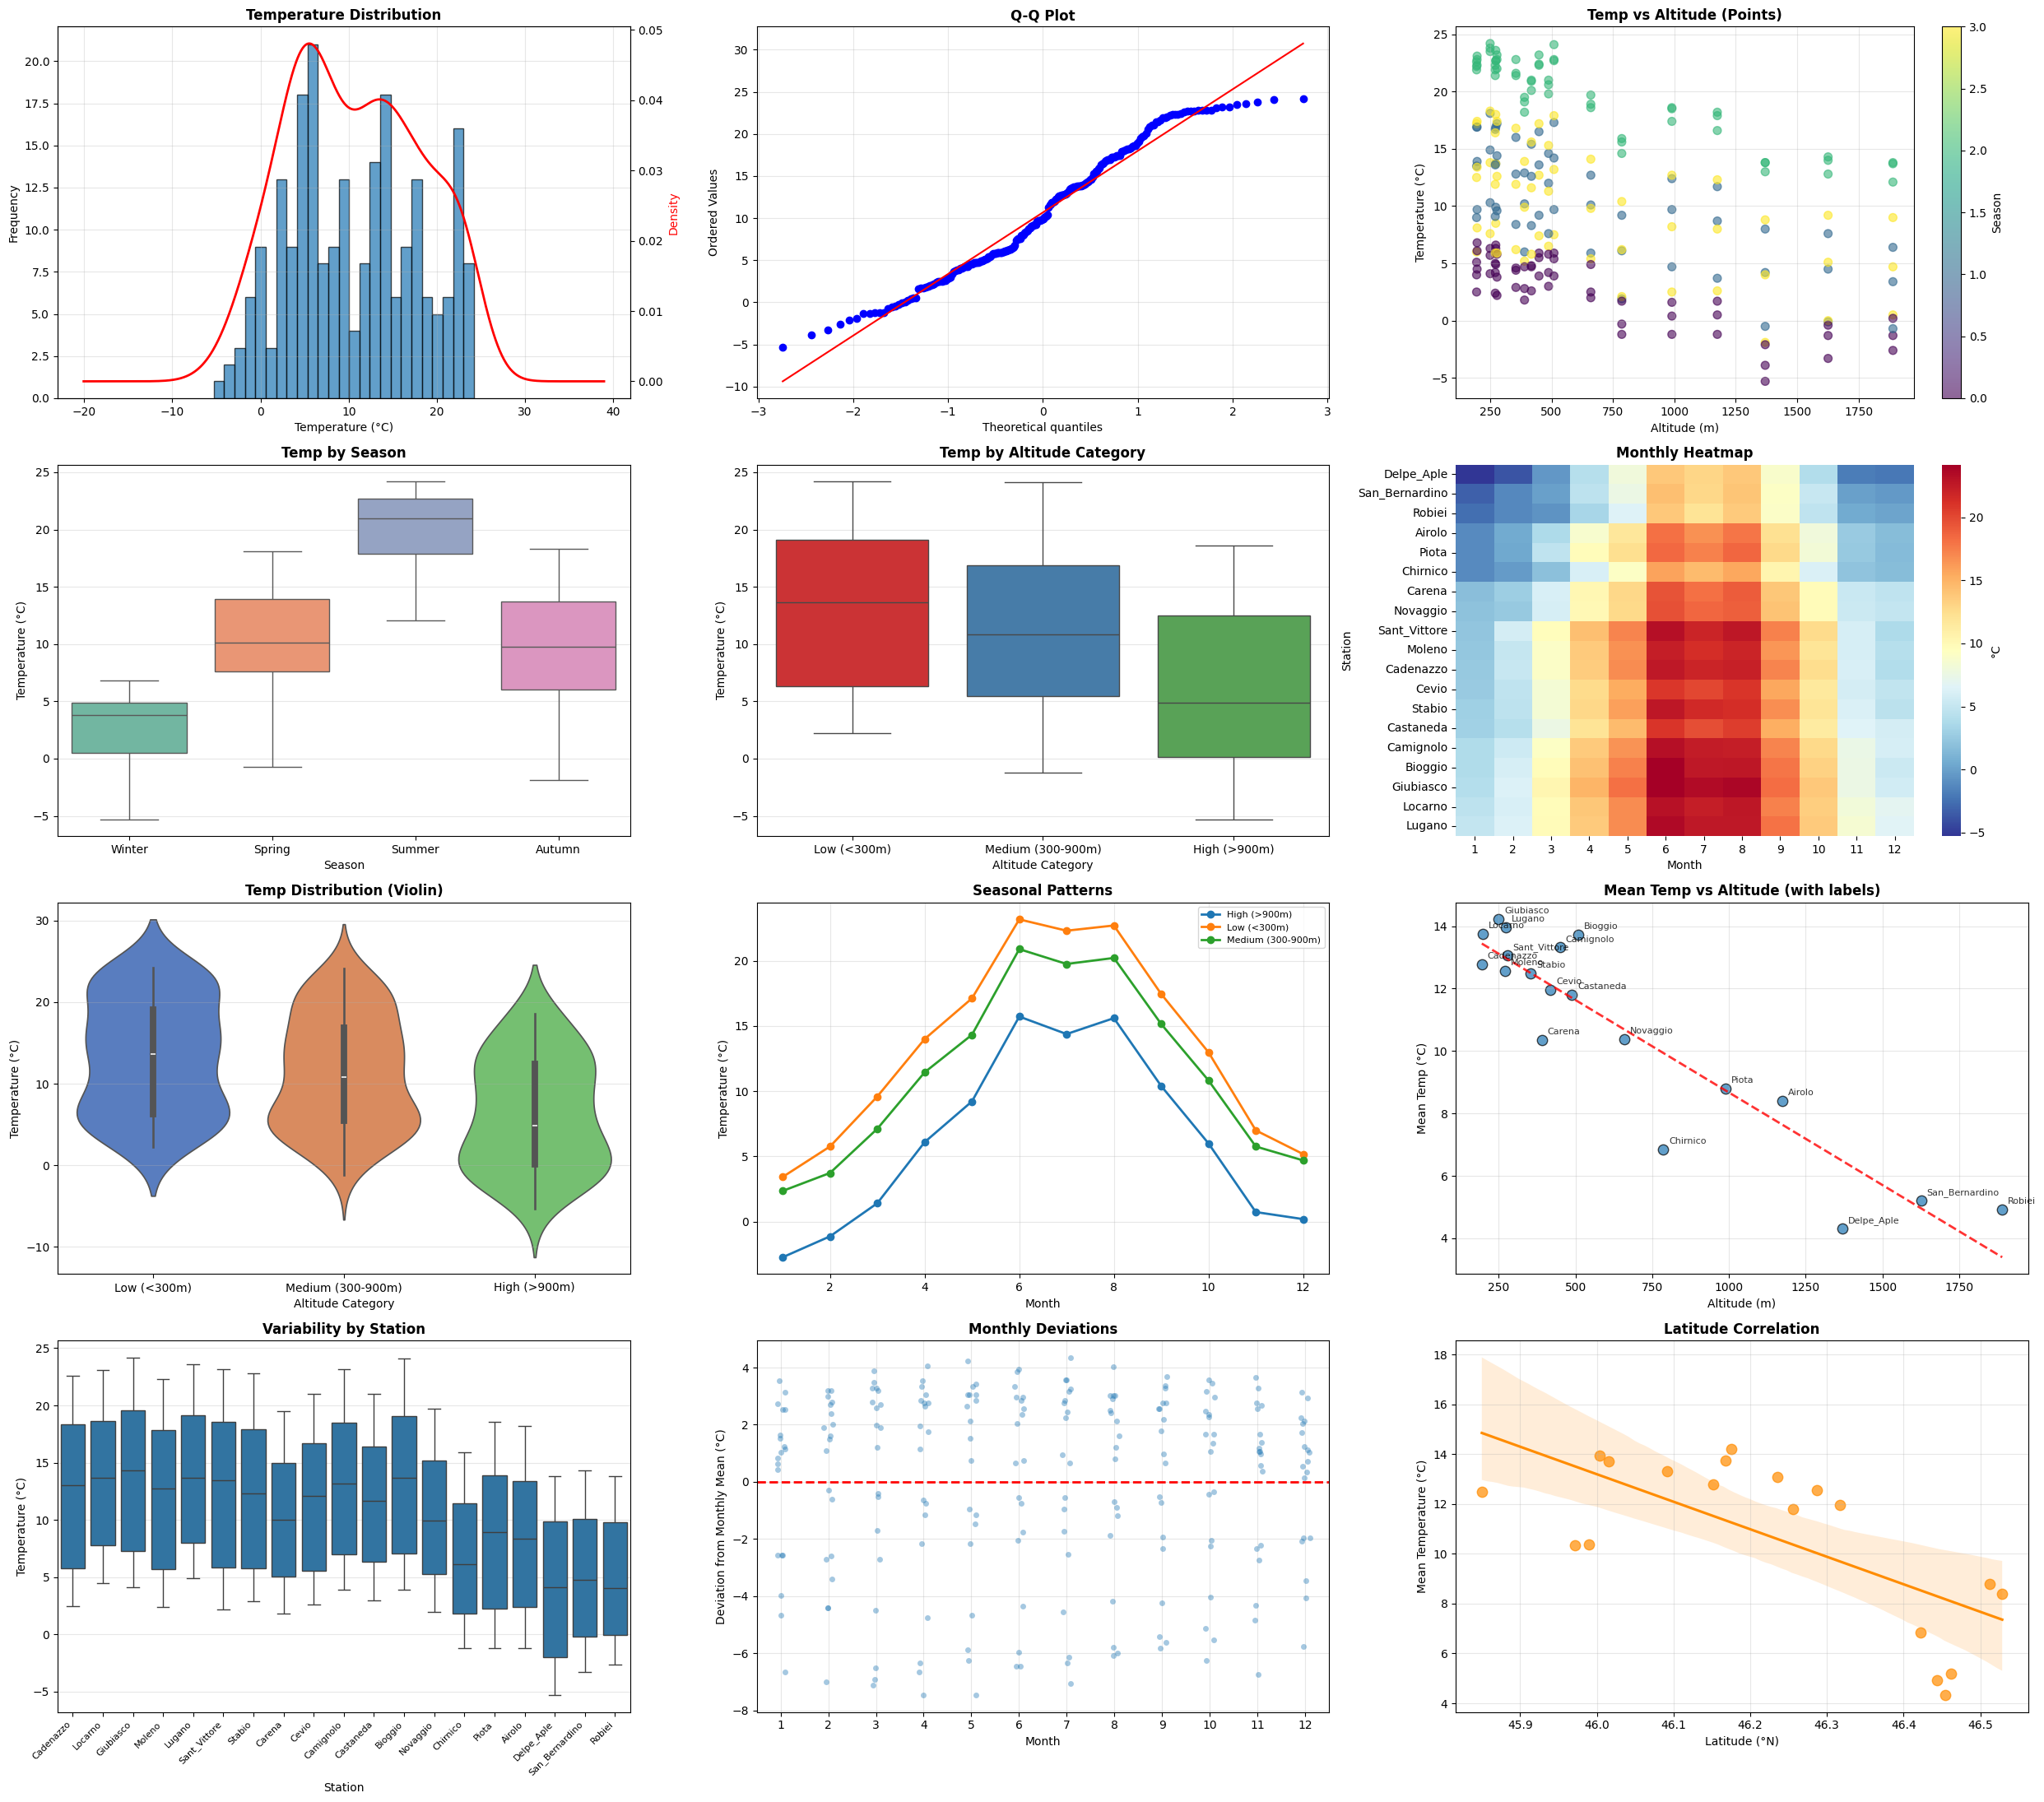

In [ ]:
fig = plt.figure(figsize=(25, 22)) 

# 2.1 Temperature Distribution
ax1 = plt.subplot(4, 3, 1)
df_final['temperature'].hist(bins=25, alpha=0.7, edgecolor='black', ax=ax1)
ax1_twin = ax1.twinx()
df_final['temperature'].plot(kind='kde', ax=ax1_twin, color='red', linewidth=2)
ax1.set_xlabel('Temperature (°C)', fontsize=10)
ax1.set_ylabel('Frequency', fontsize=10)
ax1_twin.set_ylabel('Density', fontsize=10, color='red')
ax1.set_title('Temperature Distribution', fontweight='bold')
ax1.grid(True, alpha=0.3)

# 2.2 Q-Q Plot
ax2 = plt.subplot(4, 3, 2)
stats.probplot(df_final['temperature'], dist="norm", plot=ax2)
ax2.set_title('Q-Q Plot', fontweight='bold')
ax2.grid(True, alpha=0.3)

# 2.3 Temperature vs Altitude (Scatter)
ax3 = plt.subplot(4, 3, 3)
scatter = ax3.scatter(df_final['altitude'], df_final['temperature'], alpha=0.6, s=50, c=df_final['season'], cmap='viridis')
ax3.set_xlabel('Altitude (m)', fontsize=10)
ax3.set_ylabel('Temperature (°C)', fontsize=10)
ax3.set_title('Temp vs Altitude (Points)', fontweight='bold')
ax3.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax3, label='Season')

# 2.4 Boxplot by Season
ax4 = plt.subplot(4, 3, 4)
season_labels = ['Winter', 'Spring', 'Summer', 'Autumn']
sns.boxplot(data=df_final, x='season', y='temperature', ax=ax4, palette='Set2')
ax4.set_xticklabels(season_labels)
ax4.set_xlabel('Season', fontsize=10)
ax4.set_ylabel('Temperature (°C)', fontsize=10)
ax4.set_title('Temp by Season', fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')

# 2.5 Boxplot by Altitude Category
ax5 = plt.subplot(4, 3, 5)
sns.boxplot(data=df_final, x='altitude_category', y='temperature', ax=ax5, palette='Set1')
ax5.set_xlabel('Altitude Category', fontsize=10)
ax5.set_ylabel('Temperature (°C)', fontsize=10)
ax5.set_title('Temp by Altitude Category', fontweight='bold')
ax5.grid(True, alpha=0.3, axis='y')

# 2.6 Heatmap
ax6 = plt.subplot(4, 3, 6)
pivot_temp = df_final.pivot_table(values='temperature', index='station', columns='month', aggfunc='mean')
sns.heatmap(pivot_temp.sort_values(by=1), cmap='RdYlBu_r', ax=ax6, cbar_kws={'label': '°C'})
ax6.set_xlabel('Month', fontsize=10)
ax6.set_ylabel('Station', fontsize=10)
ax6.set_title('Monthly Heatmap', fontweight='bold')

# 2.7 Violin plot
ax7 = plt.subplot(4, 3, 7)
sns.violinplot(data=df_final, x='altitude_category', y='temperature', ax=ax7, palette='muted')
ax7.set_xlabel('Altitude Category', fontsize=10)
ax7.set_ylabel('Temperature (°C)', fontsize=10)
ax7.set_title('Temp Distribution (Violin)', fontweight='bold')
ax7.grid(True, alpha=0.3, axis='y')

# 2.8 Seasonal Pattern
ax8 = plt.subplot(4, 3, 8)
for cat in sorted(df_final['altitude_category'].unique()):
    subset = df_final[df_final['altitude_category'] == cat]
    monthly_avg = subset.groupby('month')['temperature'].mean()
    ax8.plot(monthly_avg.index, monthly_avg.values, marker='o', label=cat, linewidth=2)
ax8.set_xlabel('Month', fontsize=10)
ax8.set_ylabel('Temperature (°C)', fontsize=10)
ax8.legend(fontsize=8)
ax8.set_title('Seasonal Patterns', fontweight='bold')
ax8.grid(True, alpha=0.3)

# 2.9 Mean Temp vs Altitude (Station Summary) w Labels
ax9 = plt.subplot(4, 3, 9)
station_summary = df_final.groupby('station').agg({
    'altitude': 'first', 'temperature': 'mean', 'latitude': 'first', 'longitude': 'first'
}).reset_index()

ax9.scatter(station_summary['altitude'], station_summary['temperature'], s=80, edgecolors='black', alpha=0.7)
for idx, row in station_summary.iterrows():
    ax9.annotate(row['station'], (row['altitude'], row['temperature']), 
                 fontsize=8, alpha=0.8, xytext=(5, 5), textcoords='offset points')

z = np.polyfit(station_summary['altitude'], station_summary['temperature'], 1)
p = np.poly1d(z)
ax9.plot(station_summary['altitude'].sort_values(), p(station_summary['altitude'].sort_values()), "r--", alpha=0.8, linewidth=2)
ax9.set_xlabel('Altitude (m)', fontsize=10)
ax9.set_ylabel('Mean Temp (°C)', fontsize=10)
ax9.set_title('Mean Temp vs Altitude (with labels)', fontweight='bold')
ax9.grid(True, alpha=0.3)

# 2.10 Hierarchical View
ax10 = plt.subplot(4, 3, 10)
station_order = station_summary.sort_values('altitude')['station']
sns.boxplot(data=df_final, x='station', y='temperature', order=station_order, ax=ax10)
ax10.set_xticklabels(ax10.get_xticklabels(), rotation=45, ha='right', fontsize=8)
ax10.set_xlabel('Station', fontsize=10)
ax10.set_ylabel('Temperature (°C)', fontsize=10)
ax10.set_title('Variability by Station', fontweight='bold')
ax10.grid(True, alpha=0.3, axis='y')

# 2.11 Potential Outliers (Residuals)
ax11 = plt.subplot(4, 3, 11)
df_res = df_final.copy()
df_res['res'] = df_res.groupby('month')['temperature'].transform(lambda x: x - x.mean())
sns.stripplot(data=df_res, x='month', y='res', jitter=True, alpha=0.4, ax=ax11, size=5)
ax11.axhline(0, color='red', linestyle='--', linewidth=2)
ax11.set_xlabel('Month', fontsize=10)
ax11.set_ylabel('Deviation from Monthly Mean (°C)', fontsize=10)
ax11.set_title('Monthly Deviations', fontweight='bold')
ax11.grid(True, alpha=0.3)

# 2.12 Latitude Check
ax12 = plt.subplot(4, 3, 12)
sns.regplot(data=station_summary, x='latitude', y='temperature', ax=ax12, color='darkorange', scatter_kws={'s': 80, 'alpha': 0.7})
ax12.set_xlabel('Latitude (°N)', fontsize=10)
ax12.set_ylabel('Mean Temperature (°C)', fontsize=10)
ax12.set_title('Latitude Correlation', fontweight='bold')
ax12.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

The attached visualization provides comprehensive insights across 12 key plots:

**Core Distributions:** Histogram with density overlay, Q-Q plot for normality assessment, and altitude-temperature scatter plot reveal temperature follows near-normal distribution with strong negative correlation to elevation.

**Seasonal & Spatial Patterns:** Boxplots by season and altitude category confirm summer peaks (19.7°C) and alpine cooling (6.3°C at >900m). Heatmap shows consistent warm months (June–September) across all stations.

**Station Performance:** Variability plot ranks stations by temperature range. Alpine stations (Delpe Aple, Robiei, San Bernardino) show greatest seasonal swings, while lowland stations (Lugano, Locarno, Giubiasco) remain warmer and more stable.

**Key Finding:** Mean temperature decreases ~0.6°C per 100m elevation gain, with latitude showing secondary influence (southern stations slightly warmer).

## 2.3 Correlation analysis


7. CORRELATION ANALYSIS
--------------------------------------------------------------------------------

Pearson correlation (Altitude vs Temperature): -0.4019, p-value: 2.93e-10


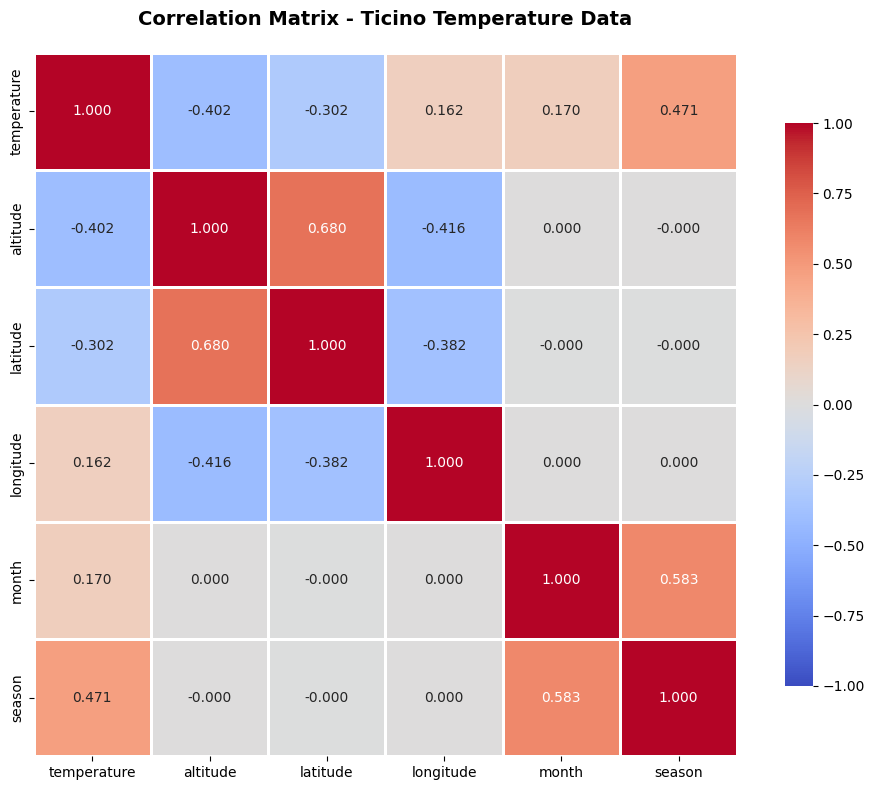

In [5]:
print("\n7. CORRELATION ANALYSIS")
print("-" * 80)
correlation_matrix = df_final[['temperature', 'altitude', 'latitude', 'longitude', 'month', 'season']].corr()

# Pearson correlation: altitude vs temperature
corr_alt_temp, p_value = stats.pearsonr(df_final['altitude'], df_final['temperature'])
print(f"\nPearson correlation (Altitude vs Temperature): {corr_alt_temp:.4f}, p-value: {p_value:.2e}")

# Heatmap della correlazione
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=ax, 
            vmin=-1, vmax=1)
ax.set_title('Correlation Matrix - Ticino Temperature Data', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Hypotesis testing N1

## Bayesian Hypothesis Test: Altitude Effect on July Temperatures

## 1. Research Question

Does temperature vary significantly between low-altitude and high-altitude stations in Ticino during July 2025?

## Hypothesis Formulation

**Null Hypothesis ($H_0$)**: The mean temperature in July 2025 is equal across low-altitude ($< 300m$) and high-altitude ($> 900m$) meteorological stations.

**Alternative Hypothesis ($H_1$)**: The mean temperature in July 2025 differs significantly between these groups, with high-altitude stations exhibiting lower temperatures.

## Rationale for Test Design

July represents the warmest month in the annual cycle, providing optimal conditions to observe the lapse rate (altitude-temperature gradient) while minimizing the "noise" of transitional seasons. By comparing stations below $300m$ (lowlands/lakes) against those above $900m$ (alpine regions), we maximize the contrast to test the atmospheric physical principles governing temperature variation with elevation.

## 2. Likelihood and Prior Specification

### Likelihood Model

We model July temperatures as independent draws from normal distributions with group-specific means and a common variance:

$$T_{ij} \sim \text{Normal}(\mu_j, \sigma^2)$$

Where:
- $T_{ij}$ is the temperature at station $i$ in group $j$ (Low or High altitude)
- $\mu_j$ is the population mean temperature for group $j$
- $\sigma$ is the common observation noise (standard deviation)

### Prior Distributions (Informed)

We use "weakly informative" priors based on our Exploratory Data Analysis (EDA) and meteorological knowledge:

**Low-altitude Mean ($\mu_{low}$)**:
$$\mu_{low} \sim \text{Normal}(22.3, 1.5)$$

**Justification**: 
- EDA of July 2025 data shows lowland mean temperature: **22.30°C** (n=6 stations)
- Observed standard deviation among low-altitude stations: 0.67°C
- Prior width $\sigma=1.5$ reflects moderate prior certainty
- Plausible range: $22.3 \pm 1.5 = [20.8, 23.8]°C$

**High-altitude Mean ($\mu_{high}$)**:
$$\mu_{high} \sim \text{Normal}(14.4, 2.5)$$

**Justification**:
- EDA of July 2025 data shows alpine mean temperature: 14.38°C (n=5 stations)
- Observed standard deviation among high-altitude stations: 2.17°C (larger variability than low-altitude)
- The observed altitude effect ($22.3 - 14.4 = 7.9°C$) exceeds the standard lapse rate (~$6.5°C/km$), reflecting Ticino's complex topography and terrain heterogeneity
- Prior width $\sigma=2.5$ accounts for greater heterogeneity in alpine regions
- Plausible range: $14.4 \pm 2.5 = [11.9, 16.9]°C$


**Standard Deviation ($\sigma$)**:
$$\sigma \sim \text{HalfNormal}(3)$$

**Justification**:
- Observed variability within altitude groups ranges from 0.67°C (low-altitude) to 2.17°C (high-altitude)
- HalfNormal(3) provides conservative bounds [0, 6]°C, accommodating both within-station and between-station variability
- Reflects typical measurement precision and local microclimatic fluctuations in Ticino
### Prior Sensitivity Analysis

To ensure our conclusions are data-driven rather than prior-driven, we conduct a sensitivity analysis using a **Diffuse Prior**:

$$\mu_{low}, \mu_{high} \sim \text{Normal}(10, 5)$$

This broader distribution represents minimal prior knowledge. Posterior inference under both priors will be compared to assess robustness.

## 3. Posterior Inference and ROPE

### Region of Practical Equivalence (ROPE)

We define the ROPE for the difference $\Delta\mu = \mu_{low} - \mu_{high}$ as:

$$\text{ROPE} = [-5°C, +5°C]$$

An effect size smaller than $5°C$ is considered climatologically negligible for operational meteorology and climate classification.

### Decision Rule

We compute three posterior probabilities:

1. **P(Δμ > 5°C | data)**: Probability that low-altitude is meaningfully warmer (altitude effect is significant)
2. **P(−5°C ≤ Δμ ≤ +5°C | data)**: Probability of practical equivalence (inside ROPE)
3. **P(Δμ < −5°C | data)**: Probability that high-altitude is meaningfully warmer (implausible)

**Conclusion criteria**:
- If **P(Δμ > 5°C | data) > 0.95**, we conclude the altitude effect is **practically and statistically significant**
- If **P(inside ROPE) > 0.80**, we conclude **practical equivalence** (no meaningful altitude effect)
- Otherwise, results are **inconclusive**

## 4. Frequentist Comparison

To bridge frequentist and Bayesian frameworks, we conduct a **Two-Sample T-test**:

$$H_0: \mu_{low} = \mu_{high} \quad \text{vs.} \quad H_A: \mu_{low} \neq \mu_{high}$$

**Metrics reported**:
- T-statistic and p-value (two-tailed)
- 95% Confidence Interval for $\mu_{low} - \mu_{high}$
- Effect size (Cohen's $d$)

**Interpretation contrast**: The frequentist p-value represents P(data | $H_0$), while the Bayesian posterior probability represents P(hypothesis | data)—a fundamentally different interpretation that we highlight in the results.

## 5. Manual Posterior Predictive Check (PPC)

As requested, we implement a custom PPC without relying on `pymc.plot_ppc`:

1. **Draw samples**: Extract 1,000 samples from the posterior distribution of $(\mu_{low}, \mu_{high}, \sigma)$
2. **Generate synthetic data**: For each posterior sample, generate synthetic July temperature observations from the fitted Normal likelihood
3. **Compare distributions**: Overlay observed July temperatures with the posterior predictive distribution (envelope/quantiles)
4. **Assess fit**: Check for systematic discrepancies suggesting model misspecification (e.g., bimodality, excess skewness, outliers)

Visualization will include:
- Histogram of observed data with posterior predictive mean and credible intervals
- Q-Q plot of observed vs. synthetic data quantiles
- Summary statistics (mean, SD, quantiles) comparison table


Initializing NUTS using jitter+adapt_diag...


Summer Data (June-Aug):
Low Altitude Stations: 18 | Mean: 22.72°C
High Altitude Stations: 15 | Mean: 15.23°C



Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_low, mu_high, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 11 seconds.


--- BAYESIAN RESULTS ---
Probability Difference > 5°C: 99.99%
Probability inside ROPE [-5, 5]: 0.01%
           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu_low   22.704  0.395  21.953   23.438      0.005    0.005    7049.0   
mu_high  15.209  0.444  14.352   16.034      0.005    0.006    7198.0   
sigma     1.716  0.226   1.345    2.172      0.003    0.003    6657.0   

         ess_tail  r_hat  
mu_low     5461.0    1.0  
mu_high    5341.0    1.0  
sigma      5441.0    1.0  

--- FREQUENTIST COMPARISON ---
T-statistic: 12.89970
P-value: 0.00000 (Significant if < 0.05)


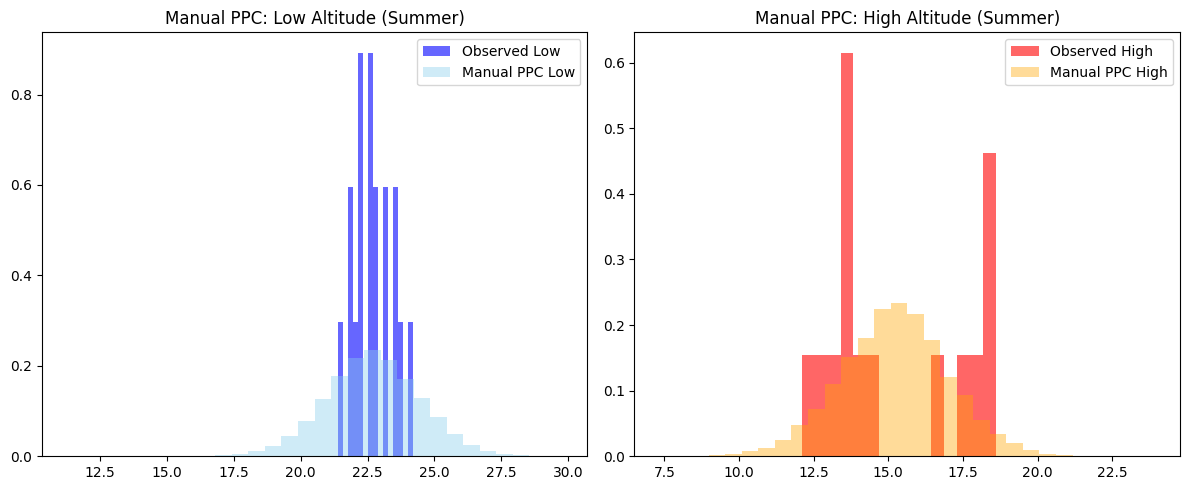

In [7]:
# 1. DATA PREPARATION (Extended to Summer: June, July, August)
# Filter for summer months (6, 7, 8)
df_summer = df_final[df_final['month'].isin([6, 7, 8])].copy()

# Define populations based on altitude thresholds 
temp_low = df_summer[df_summer['altitude'] < 300]['temperature'].values
temp_high = df_summer[df_summer['altitude'] > 900]['temperature'].values

print(f"Summer Data (June-Aug):")
print(f"Low Altitude Stations: {len(temp_low)} | Mean: {temp_low.mean():.2f}°C")
print(f"High Altitude Stations: {len(temp_high)} | Mean: {temp_high.mean():.2f}°C\n")

# 2. BAYESIAN MODEL 
with pm.Model() as model_informed:
    # Priors: We keep the same informed priors, but note that sigma might increase 
    # due to the natural temperature variation between June and August.
    mu_low = pm.Normal('mu_low', mu=22.3, sigma=1.5)
    mu_high = pm.Normal('mu_high', mu=14.4, sigma=2.5)
    
    # We assume equal variances for both populations as a starting point 
    sigma = pm.HalfNormal('sigma', sigma=3)
    
    # Likelihood: Normal distribution for temperature [cite: 58]
    y_low = pm.Normal('y_low', mu=mu_low, sigma=sigma, observed=temp_low)
    y_high = pm.Normal('y_high', mu=mu_high, sigma=sigma, observed=temp_high)
    
    # Difference calculation (Deterministic)
    diff = pm.Deterministic('diff', mu_low - mu_high)
    
    # Sampling: Running MCMC chains to obtain the posterior distribution
    trace_inf = pm.sample(2000, tune=1000, target_accept=0.9, return_inferencedata=True)

# 3. ROPE ANALYSIS AND RESULTS
post_diff = trace_inf.posterior['diff'].values.flatten()
# ROPE defines the range of practical equivalence where the difference is negligible 
p_greater_1 = np.mean(post_diff > 5)
p_rope = np.mean((post_diff >= -5) & (post_diff <= 5))

print(f"--- BAYESIAN RESULTS ---")
print(f"Probability Difference > 5°C: {p_greater_1*100:.2f}%")
print(f"Probability inside ROPE [-5, 5]: {p_rope*100:.2f}%")

print(az.summary(trace_inf, var_names=['mu_low', 'mu_high', 'sigma']))

# 4. FREQUENTIST TEST (Comparison)
# We perform a two-sample t-test to check for statistical significance 
# H0: mu_low = mu_high | H1: mu_low != mu_high 
t_stat, p_val = stats.ttest_ind(temp_low, temp_high)
print(f"\n--- FREQUENTIST COMPARISON ---")
print(f"T-statistic: {t_stat:.5f}")
print(f"P-value: {p_val:.5f} (Significant if < 0.05)")

# 5. MANUAL POSTERIOR PREDICTIVE CHECK (PPC)
# Extracting 1000 draws to generate synthetic observations
draws = az.extract(trace_inf, num_samples=1000)
mu_low_s = draws['mu_low'].values
mu_high_s = draws['mu_high'].values
sigma_s = draws['sigma'].values

# Predictive Distribution: Generating new data based on the model's parameters
n_draws = 1000
# ppc_low_manual = np.random.normal(mu_low_s, sigma_s)
ppc_low_manual = np.array([np.random.normal(mu_low_s[i], sigma_s[i], size=len(temp_low)) for i in range(n_draws)])
# ppc_high_manual = np.random.normal(mu_high_s, sigma_s)
ppc_high_manual = np.array([np.random.normal(mu_high_s[i], sigma_s[i], size=len(temp_high)) for i in range(n_draws)])

# Visualization of the fit
plt.figure(figsize=(12, 5))

# Subplot 1: Low Altitude (Observed vs Predicted)
plt.subplot(1, 2, 1)
plt.hist(temp_low, bins=15, density=True, alpha=0.6, label='Observed Low', color='blue')
plt.hist(ppc_low_manual.flatten(), bins=30, density=True, alpha=0.4, label='Manual PPC Low', color='skyblue')
plt.title("Manual PPC: Low Altitude (Summer)")
plt.legend()

# Subplot 2: High Altitude (Observed vs Predicted)
plt.subplot(1, 2, 2)
plt.hist(temp_high, bins=15, density=True, alpha=0.6, label='Observed High', color='red')
plt.hist(ppc_high_manual.flatten(), bins=30, density=True, alpha=0.4, label='Manual PPC High', color='orange')
plt.title("Manual PPC: High Altitude (Summer)")
plt.legend()

plt.tight_layout()
plt.show()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_low_diff, mu_high_diff, sigma_diff]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 11 seconds.


PRIOR SENSITIVITY COMPARISON
Informed Prior - Mean Difference: 7.49°C
Diffuse Prior  - Mean Difference: 7.45°C


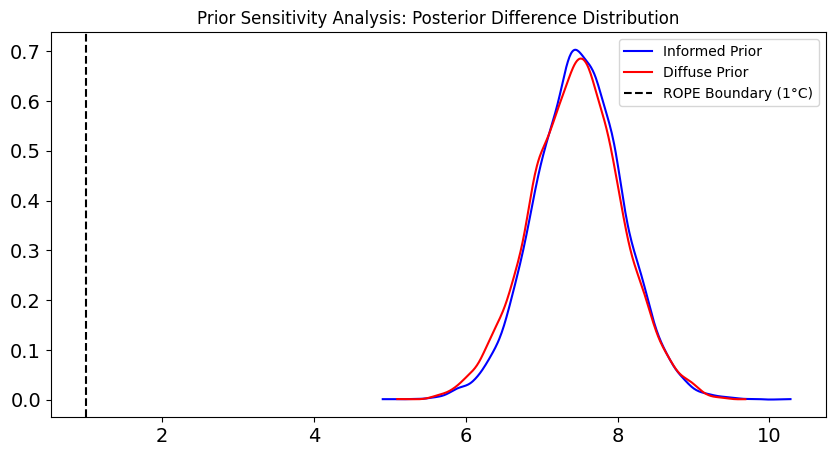

In [8]:
# 6. PRIOR SENSITIVITY ANALYSIS (Diffuse Prior)
with pm.Model() as model_diffuse:

    mu_low_diff = pm.Normal('mu_low_diff', mu=10, sigma=5)
    mu_high_diff = pm.Normal('mu_high_diff', mu=10, sigma=5)
    sigma_diff = pm.HalfNormal('sigma_diff', sigma=3)
    
    # Likelihood (same as before)
    y_low = pm.Normal('y_low', mu=mu_low_diff, sigma=sigma_diff, observed=temp_low)
    y_high = pm.Normal('y_high', mu=mu_high_diff, sigma=sigma_diff, observed=temp_high)
    
    diff_diffuse = pm.Deterministic('diff_diffuse', mu_low_diff - mu_high_diff)
    
    trace_diff = pm.sample(2000, tune=1000, target_accept=0.9, return_inferencedata=True, progressbar=False)

# Compare Results
post_diff_inf = trace_inf.posterior['diff'].values.flatten()
post_diff_diff = trace_diff.posterior['diff_diffuse'].values.flatten()

print(f"PRIOR SENSITIVITY COMPARISON")
print(f"Informed Prior - Mean Difference: {post_diff_inf.mean():.2f}°C")
print(f"Diffuse Prior  - Mean Difference: {post_diff_diff.mean():.2f}°C")

# Plotting the comparison
plt.figure(figsize=(10, 5))
az.plot_dist(post_diff_inf, color="blue", label="Informed Prior")
az.plot_dist(post_diff_diff, color="red", label="Diffuse Prior")
plt.axvline(1, color='black', linestyle='--', label='ROPE Boundary (1°C)')
plt.title("Prior Sensitivity Analysis: Posterior Difference Distribution")
plt.legend()
plt.show()

# Regression

In [9]:
with pm.Model() as regression_model:
    # aplha -> degress at 0 m 
    # beta -> + degress per metro
    # 1. PRIORS 
    alpha = pm.Normal('alpha', mu=28, sigma=5) 
    beta = pm.Normal('beta', mu=-0.006, sigma=0.002)
    sigma = pm.HalfNormal('sigma', sigma=2) # L'errore del modello
    
    # 2. equaz retta
    mu = alpha + beta * df_summer['altitude']
    
    # 3. LIKELIHOOD (Come i dati si distribuiscono attorno alla retta)
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=df_summer['temperature'])
    
    # 4. SAMPLING 
    trace_reg = pm.sample(2000, return_inferencedata=True, target_accept=0.9, idata_kwargs={"log_likelihood": True})
print("\n=== NORMAL REGRESSION SUMMARY ===")
print(az.summary(trace_reg, var_names=['alpha', 'beta', 'sigma']))

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 54 seconds.



=== NORMAL REGRESSION SUMMARY ===
         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha  23.926  0.334  23.319   24.574      0.005    0.004    3865.0    3842.0   
beta   -0.006  0.000  -0.007   -0.006      0.000    0.000    3809.0    3899.0   
sigma   1.562  0.150   1.292    1.841      0.002    0.002    4978.0    5083.0   

       r_hat  
alpha    1.0  
beta     1.0  
sigma    1.0  


In [10]:
with pm.Model() as robust_regression_model:
    alpha = pm.Normal('alpha', mu=28, sigma=5)
    beta = pm.Normal('beta', mu=-0.006, sigma=0.002)
    sigma = pm.HalfNormal('sigma', sigma=2)
    
    # nu -> gradi di libertà per student-T
    nu = pm.Exponential('nu', 1/10) 
    
    mu = alpha + beta * df_summer['altitude']
    
    # Likelihood ROBUSTA
    y_obs = pm.StudentT('y_obs', nu=nu, mu=mu, sigma=sigma, observed=df_summer['temperature'])
    
    trace_robust = pm.sample(2000, return_inferencedata=True, target_accept=0.9, idata_kwargs={"log_likelihood": True})

print("\n=== ROBUST REGRESSION SUMMARY ===")
print(az.summary(trace_robust, var_names=['alpha', 'beta', 'sigma', 'nu']))

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma, nu]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 155 seconds.



=== ROBUST REGRESSION SUMMARY ===
         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha  23.975  0.314  23.393   24.568      0.005    0.004    4198.0    4616.0   
beta   -0.006  0.000  -0.007   -0.006      0.000    0.000    4091.0    4295.0   
sigma   1.372  0.188   1.035    1.740      0.003    0.002    4588.0    3765.0   
nu     12.340  9.653   1.602   29.706      0.135    0.214    4790.0    4582.0   

       r_hat  
alpha    1.0  
beta     1.0  
sigma    1.0  
nu       1.0  


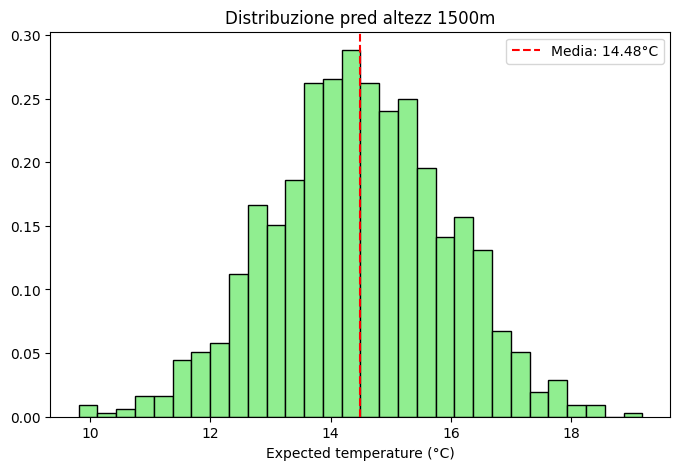

In [11]:
# Tets altitutdin
altitude_test = 1500

# parameters of robust
draws_robust = az.extract(trace_robust, num_samples=1000)
alpha_samples = draws_robust['alpha'].values
beta_samples = draws_robust['beta'].values
sigma_samples = draws_robust['sigma'].values

# prediction for test
temp_pred = alpha_samples + beta_samples * altitude_test + np.random.normal(0, sigma_samples)

plt.figure(figsize=(8, 5))
plt.hist(temp_pred, bins=30, color='lightgreen', edgecolor='black', density=True)
plt.axvline(temp_pred.mean(), color='red', linestyle='--', label=f'Media: {temp_pred.mean():.2f}°C')
plt.title(f"Distribuzione pred altezz {altitude_test}m")
plt.xlabel("Expected temperature (°C)")
plt.legend()
plt.show()

The predictive distribution for an observation at 1500m shows an average of 14.54°C. The width of the distribution reflects both the uncertainty in the model parameters ($\alpha, \beta$) and the residual variance ($\sigma$) captured by the historical data. This approach is superior to classical regression because it provides not just a single number, but the entire spectrum of probabilities.


WAIC MODEL COMPARISON: Normal vs Robust Regression

Normal Regression WAIC: 214.54
Robust (Student-t) WAIC: 214.40
Difference: -0.14
→ Robust model predicts BETTER


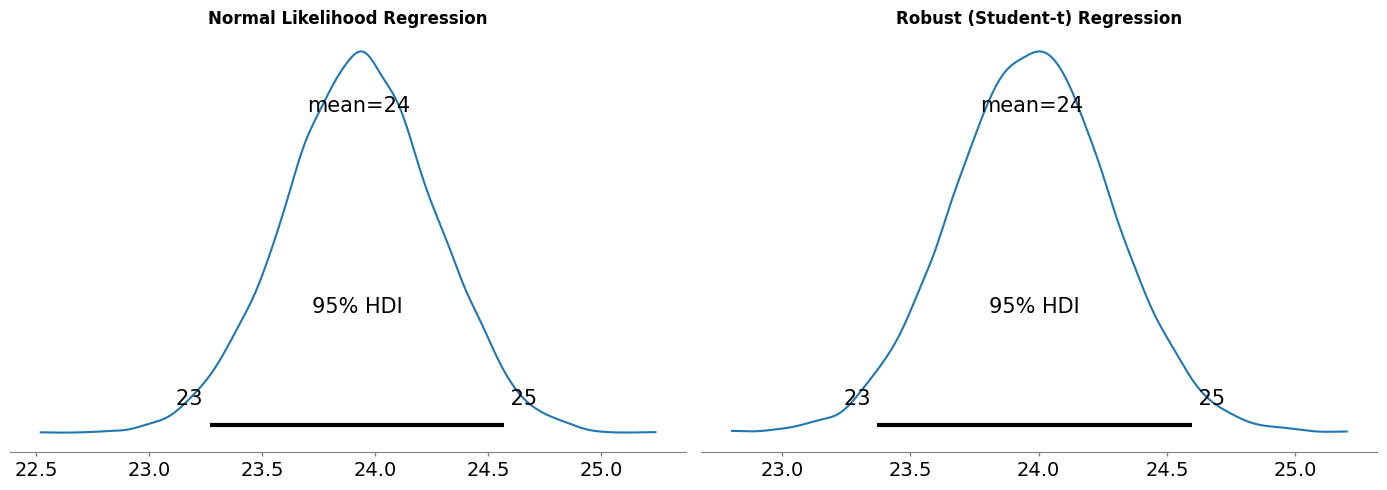


POSTERIOR PREDICTIVE DISTRIBUTION at altitude = 1500m

NORMAL MODEL:
  Predicted mean temperature: 14.43°C
  Std dev: 1.59°C
  95% Credible Interval: [11.51, 17.59]°C

ROBUST MODEL (Student-t):
  Predicted mean temperature: 14.54°C
  Std dev: 1.43°C
  95% Credible Interval: [11.84, 17.57]°C


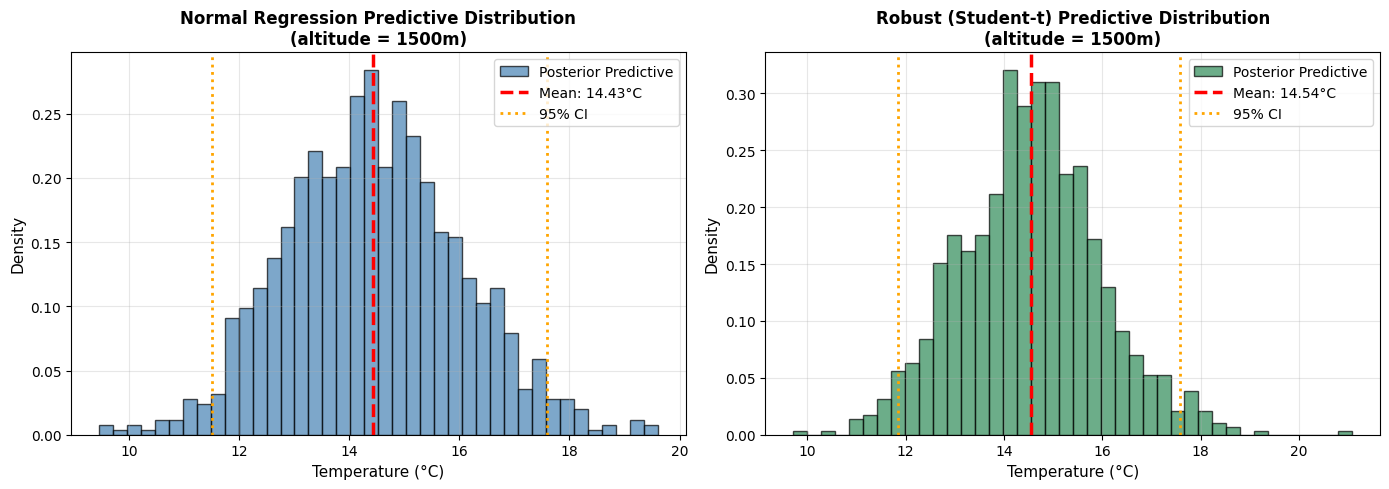


REGRESSION MODEL SECTION COMPLETE


In [ ]:
print("\n" + "="*70)
print("WAIC MODEL COMPARISON: Normal vs Robust Regression")
print("="*70)

# # Dopo entrambi i pm.sample()
# with regression_model:
#     pm.compute_log_likelihood(trace_reg)

# with robust_regression_model:
#     pm.compute_log_likelihood(trace_robust)

# Adesso puoi fare il WAIC
waic_normal = az.waic(trace_reg, scale='deviance')
waic_robust = az.waic(trace_robust, scale='deviance')

print(f"\nNormal Regression WAIC: {float(waic_normal.iloc[0]):.2f}")
print(f"Robust (Student-t) WAIC: {float(waic_robust.iloc[0]):.2f}")
print(f"Difference: {float(waic_robust.iloc[0] - waic_normal.iloc[0]):.2f}")

if float(waic_robust.iloc[0]) < float(waic_normal.iloc[0]):
    print("→ Robust model predicts BETTER")
else:
    print("→ Normal model is sufficient")

# Posterior comparison plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

az.plot_posterior(trace_reg, var_names=['alpha', 'beta'], ax=axes[0], hdi_prob=0.95)
axes[0].set_title('Normal Likelihood Regression', fontsize=12, fontweight='bold')

az.plot_posterior(trace_robust, var_names=['alpha', 'beta'], ax=axes[1], hdi_prob=0.95)
axes[1].set_title('Robust (Student-t) Regression', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# ============================================================================
# PARTE 3: PREDICTIVE DISTRIBUTION 
# ============================================================================

altitude_test = 1500

print("\n" + "="*70)
print(f"POSTERIOR PREDICTIVE DISTRIBUTION at altitude = {altitude_test}m")
print("="*70)

# NORMAL MODEL
draws_normal = az.extract(trace_reg, num_samples=1000)
alpha_n = draws_normal['alpha'].values
beta_n = draws_normal['beta'].values
sigma_n = draws_normal['sigma'].values

mu_n = alpha_n + beta_n * altitude_test
y_pred_n = mu_n + np.random.normal(0, sigma_n)

# ROBUST MODEL
draws_robust = az.extract(trace_robust, num_samples=1000)
alpha_r = draws_robust['alpha'].values
beta_r = draws_robust['beta'].values
sigma_r = draws_robust['sigma'].values

mu_r = alpha_r + beta_r * altitude_test
y_pred_r = mu_r + np.random.normal(0, sigma_r)

# PRINT RESULTS
print("\nNORMAL MODEL:")
print(f"  Predicted mean temperature: {y_pred_n.mean():.2f}°C")
print(f"  Std dev: {y_pred_n.std():.2f}°C")
print(f"  95% Credible Interval: [{np.percentile(y_pred_n, 2.5):.2f}, {np.percentile(y_pred_n, 97.5):.2f}]°C")

print("\nROBUST MODEL (Student-t):")
print(f"  Predicted mean temperature: {y_pred_r.mean():.2f}°C")
print(f"  Std dev: {y_pred_r.std():.2f}°C")
print(f"  95% Credible Interval: [{np.percentile(y_pred_r, 2.5):.2f}, {np.percentile(y_pred_r, 97.5):.2f}]°C")

# VISUALIZATION
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Normal Model
axes[0].hist(y_pred_n, bins=40, alpha=0.7, label='Posterior Predictive', 
             color='steelblue', edgecolor='black', density=True)
axes[0].axvline(y_pred_n.mean(), color='red', linestyle='--', linewidth=2.5, 
                label=f'Mean: {y_pred_n.mean():.2f}°C')
axes[0].axvline(np.percentile(y_pred_n, 2.5), color='orange', linestyle=':', 
                linewidth=2, label='95% CI')
axes[0].axvline(np.percentile(y_pred_n, 97.5), color='orange', linestyle=':', linewidth=2)
axes[0].set_xlabel('Temperature (°C)', fontsize=11)
axes[0].set_ylabel('Density', fontsize=11)
axes[0].set_title(f'Normal Regression Predictive Distribution\n(altitude = {altitude_test}m)', 
                  fontweight='bold', fontsize=12)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Robust Model
axes[1].hist(y_pred_r, bins=40, alpha=0.7, label='Posterior Predictive', 
             color='seagreen', edgecolor='black', density=True)
axes[1].axvline(y_pred_r.mean(), color='red', linestyle='--', linewidth=2.5, 
                label=f'Mean: {y_pred_r.mean():.2f}°C')
axes[1].axvline(np.percentile(y_pred_r, 2.5), color='orange', linestyle=':', 
                linewidth=2, label='95% CI')
axes[1].axvline(np.percentile(y_pred_r, 97.5), color='orange', linestyle=':', linewidth=2)
axes[1].set_xlabel('Temperature (°C)', fontsize=11)
axes[1].set_ylabel('Density', fontsize=11)
axes[1].set_title(f'Robust (Student-t) Predictive Distribution\n(altitude = {altitude_test}m)', 
                  fontweight='bold', fontsize=12)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("REGRESSION MODEL SECTION COMPLETE")
print("="*70)


# Bayesian Hypothesis Test N2: Latitude Effect on Winter Temperatures

Author: Alessio Carnevale

## Research Question

Does temperature vary significantly between Northern and Southern stations in Ticino during the Winter of 2025?

Hypothesis Formulation

**Null Hypothesis ($H_0$)**: The mean temperature in Winter (Dec, Jan, Feb) is equal across Southern (Low Latitude) and Northern (High Latitude) meteorological stations.

**Alternative Hypothesis ($H_1$)**: The mean temperature in Winter differs significantly between these groups, with Southern stations exhibiting higher temperatures.

Rationale for Test Design

Winter represents the season of minimum solar incidence. By comparing Southern stations (closer to the Lombardy plains) against Northern stations (closer to the Alps), we aim to isolate the geographical latitude effect—potentially driven by solar angle and orographic shadowing—independent of the lapse rate. We define the split based on the median latitude of the dataset.

## Likelihood and Prior Specification

Likelihood Model

We model Winter temperatures as independent draws from normal distributions with group-specific means and group-specific standard deviations:

$$T_{ij} \sim \text{Normal}(\mu_j, \sigma_j^2)$$

Where:

$T_{ij}$ is the temperature at station $i$ in group $j$ (South or North)

$\mu_j$ is the population mean temperature for group $j$

$\sigma_j$ is the observation noise (standard deviation) for group $j$

Prior Distributions (Weakly Informative)

We use "weakly informative" priors that constrain the parameter space to physically plausible values for Winter in Switzerland without imposing strong bias:

Group Means ($\mu_{south}, \mu_{north}$):


$$\mu \sim \text{Normal}(0, 10)$$

Justification:

Center (0°C): Represents a reasonable baseline for winter temperatures in this region.

Width ($\sigma=10$): The interval $\pm 2\sigma$ covers $[-20°C, +20°C]$, which encompasses everything from mild lake-effect days to severe alpine cold snaps. This allows the data to dominate the posterior.

Standard Deviations ($\sigma_{south}, \sigma_{north}$):


$$\sigma \sim \text{HalfNormal}(10)$$

Justification:

Enforces positivity.

A scale of 10 allows for significant variability (weather fluctuations) within the season, but discourages physically impossible variance values (e.g., 100°C swings within a month).

Prior Sensitivity Analysis

To ensure our conclusions are data-driven rather than prior-driven, we conduct a sensitivity analysis using a Diffuse/Flat Prior:

$$\mu \sim \text{Normal}(0, 100)$$

$$\sigma \sim \text{HalfNormal}(100)$$

This extremely broad distribution represents near-total ignorance. We check if the posterior distribution of the difference ($\Delta\mu$) remains stable under these looser assumptions.

## Posterior Inference and ROPE

Region of Practical Equivalence (ROPE)

We define the ROPE for the difference $\Delta\mu = \mu_{south} - \mu_{north}$ as:

$$\text{ROPE} = [-0.5°C, +0.5°C]$$

An effect size smaller than $0.5°C$ is considered meteorologically negligible for this specific regional comparison.

Decision Rule

We compute three posterior probabilities:

P(Δμ > 0.5°C | data): Probability that the South is meaningfully warmer.

P(−0.5°C ≤ Δμ ≤ +0.5°C | data): Probability of practical equivalence (no meaningful latitude effect).

P(Δμ < −0.5°C | data): Probability that the North is meaningfully warmer.

Conclusion criteria:

If P(Δμ > 0.5°C | data) > 0.95, we conclude the latitude effect is practically and statistically significant.

If P(inside ROPE) > 0.95, we conclude practical equivalence (latitude has no effect).

Otherwise, results are inconclusive.

## Frequentist Comparison

To bridge frequentist and Bayesian frameworks, we conduct a Welch's Two-Sample T-test (assuming unequal variances):

$$H_0: \mu_{south} = \mu_{north} \quad \text{vs.} \quad H_A: \mu_{south} \neq \mu_{north}$$

Metrics reported:

T-statistic and p-value.

Comparison of the p-value against the Bayesian probability of direction.

Interpretation contrast: The frequentist p-value tests the probability of the data assuming the null is true, while our Bayesian analysis gives the probability that the South is warmer given the data.

## Manual Posterior Predictive Check (PPC)

We implement a custom PPC without relying on pymc.sample_posterior_predictive:

Draw samples: Extract 100 random parameter pairs $(\mu, \sigma)$ from the posterior trace for the Southern group.

Generate synthetic data: For each pair, generate a synthetic dataset of winter temperatures using numpy.random.normal.

Compare distributions: Plot the Kernel Density Estimate (KDE) of the observed Southern temperatures (Black Line) against the 100 synthetic datasets (Green Lines).

Assess fit:

Good fit: The observed black line sits comfortably within the "cloud" of green synthetic lines.

Bad fit: The observed line deviates significantly (e.g., has tails or peaks that the model does not reproduce).

In [13]:
df = pd.read_csv('ticino_temperature_2025.csv')

Initializing NUTS using jitter+adapt_diag...



[Step 1] Data Preparation & Grouping
   -> Split Criterion: Median Latitude 46.2350°N
   -> Southern Group (n=10): Mean = 4.53°C
   -> Northern Group (n=9): Mean = 0.69°C

[Step 2] Bayesian Model Construction (BEST)
   -> Likelihood: Normal(mu, sigma)
   -> Priors: mu ~ Normal(0, 10), sigma ~ HalfNormal(10)


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_south, mu_north, sigma_south, sigma_north]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 9 seconds.
Initializing NUTS using jitter+adapt_diag...



[Step 3] Prior Sensitivity Analysis
   -> Running model with Flat Priors (SD=100) to check robustness...


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_south, mu_north, sigma_south, sigma_north]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 9 seconds.


   -> Main Model Mean Diff: 3.829°C
   -> Sensitivity Model Mean Diff: 3.828°C


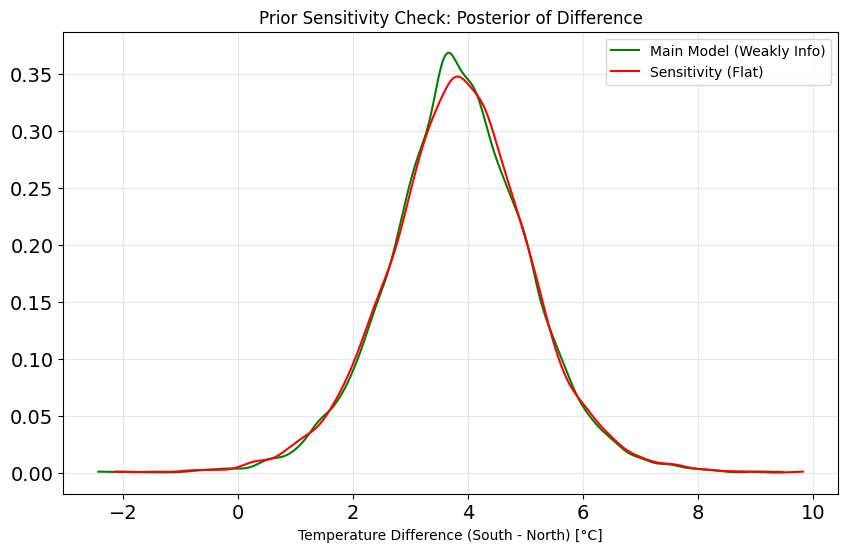

   -> Sensitivity Plot displayed.

[Step 4] Inference & ROPE Analysis
   -> ROPE Interval defined as: [-0.5°C, 0.5°C]


<Figure size 1000x600 with 0 Axes>

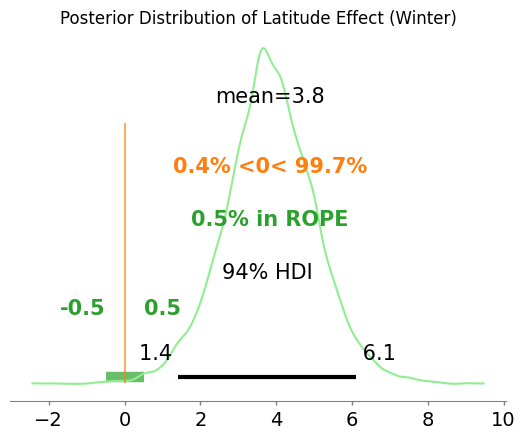

   -> ROPE Plot displayed.
   -> P(Difference > 0.5°C): 0.9932
   -> P(Inside ROPE): 0.0050

[Step 5] Final Conclusion (Based on 95% threshold)
   ✅ CONCLUSION: Significant Latitude Effect.
   The probability that Southern stations are practically warmer (>0.5°C diff) is > 95%.

[Step 6] Frequentist Sanity Check (Welch's T-Test)
   -> T-Statistic: 3.8246
   -> P-Value: 3.3625e-03
   -> Frequentist Result: Significant Difference (p < 0.05)

[Step 7] Custom Posterior Predictive Check
   -> Generating synthetic datasets from posterior trace...


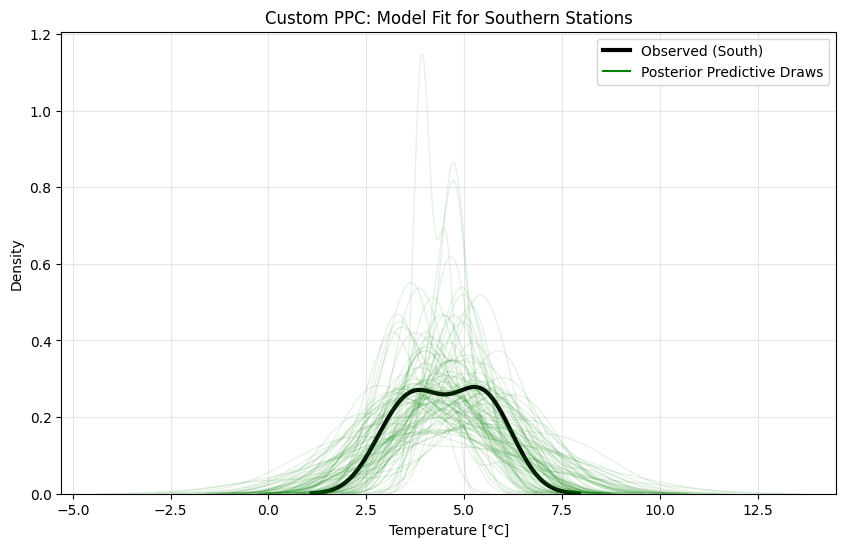

   -> PPC Plot displayed.

Analysis Run Complete.


In [14]:
print("\n[Step 1] Data Preparation & Grouping")

# 1. Filter for Winter Months (Dec=12, Jan=1, Feb=2)
df_winter = df[df['month'].isin([12, 1, 2])].copy()

# 2. Define Groups by Median Latitude Split
median_lat = df_winter['latitude'].median()

# Aggregate average winter temperature per station (Unit of Analysis = Station)
station_winter_avg = df_winter.groupby(['station', 'latitude'])['temperature'].mean().reset_index()

# Split into South (Lat <= Median) and North (Lat > Median)
group_south = station_winter_avg[station_winter_avg['latitude'] <= median_lat]['temperature'].values
group_north = station_winter_avg[station_winter_avg['latitude'] > median_lat]['temperature'].values

print(f"   -> Split Criterion: Median Latitude {median_lat:.4f}°N")
print(f"   -> Southern Group (n={len(group_south)}): Mean = {np.mean(group_south):.2f}°C")
print(f"   -> Northern Group (n={len(group_north)}): Mean = {np.mean(group_north):.2f}°C")

# ==========================================
# 3. BAYESIAN MODELING
# ==========================================
print("\n[Step 2] Bayesian Model Construction (BEST)")
print("   -> Likelihood: Normal(mu, sigma)")
print("   -> Priors: mu ~ Normal(0, 10), sigma ~ HalfNormal(10)")

def run_bayesian_model(g1, g2, prior_mu_sd=10, prior_sigma_sd=10, label="Standard"):
    with pm.Model() as model:
        # --- Priors ---
        # Weakly informative priors centered at 0C
        mu_south = pm.Normal("mu_south", mu=0, sigma=prior_mu_sd)
        mu_north = pm.Normal("mu_north", mu=0, sigma=prior_mu_sd)
        
        # Standard deviations
        sigma_south = pm.HalfNormal("sigma_south", sigma=prior_sigma_sd)
        sigma_north = pm.HalfNormal("sigma_north", sigma=prior_sigma_sd)
        
        # --- Likelihood ---
        obs_south = pm.Normal("obs_south", mu=mu_south, sigma=sigma_south, observed=g1)
        obs_north = pm.Normal("obs_north", mu=mu_north, sigma=sigma_north, observed=g2)
        
        # --- Deterministic ---
        # Difference: South - North
        diff_means = pm.Deterministic("diff_means", mu_south - mu_north)
        
        # --- Sampling ---
        # Using 2000 draws to ensure stable probabilities
        trace = pm.sample(2000, tune=1000, return_inferencedata=True, progressbar=False)
    
    return model, trace

# Run Main Model
model_main, trace_main = run_bayesian_model(group_south, group_north, label="Main Model")

# ==========================================
# 4. PRIOR SENSITIVITY ANALYSIS
# ==========================================
print("\n[Step 3] Prior Sensitivity Analysis")
print("   -> Running model with Flat Priors (SD=100) to check robustness...")

# Run Sensitivity Model
model_sens, trace_sens = run_bayesian_model(group_south, group_north, prior_mu_sd=100, prior_sigma_sd=100, label="Sensitivity")

# Calculate means of posterior means for comparison
mean_diff_main = trace_main.posterior["diff_means"].mean().item()
mean_diff_sens = trace_sens.posterior["diff_means"].mean().item()

print(f"   -> Main Model Mean Diff: {mean_diff_main:.3f}°C")
print(f"   -> Sensitivity Model Mean Diff: {mean_diff_sens:.3f}°C")

# Visual Comparison
plt.figure(figsize=(10, 6))
az.plot_dist(trace_main.posterior["diff_means"], label="Main Model (Weakly Info)", color="green")
az.plot_dist(trace_sens.posterior["diff_means"], label="Sensitivity (Flat)", color="red")
plt.title("Prior Sensitivity Check: Posterior of Difference")
plt.xlabel("Temperature Difference (South - North) [°C]")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
print("   -> Sensitivity Plot displayed.")

# ==========================================
# 5. POSTERIOR INFERENCE & ROPE
# ==========================================
print("\n[Step 4] Inference & ROPE Analysis")
# ROPE Definition: [-0.5, 0.5]
rope_low, rope_high = -0.5, 0.5
print(f"   -> ROPE Interval defined as: [{rope_low}°C, {rope_high}°C]")

# Plotting Posterior with ROPE
plt.figure(figsize=(10, 6))
az.plot_posterior(
    trace_main, 
    var_names=["diff_means"], 
    ref_val=0, 
    rope=[rope_low, rope_high],
    color='lightgreen'
)
plt.title("Posterior Distribution of Latitude Effect (Winter)")
plt.show()
print("   -> ROPE Plot displayed.")

# Probability Calculations
posterior_diff = trace_main.posterior["diff_means"].values.flatten()
prob_positive = (posterior_diff > rope_high).mean() # Probability South is strictly warmer
prob_rope = ((posterior_diff >= rope_low) & (posterior_diff <= rope_high)).mean() # Probability of equivalence

print(f"   -> P(Difference > {rope_high}°C): {prob_positive:.4f}")
print(f"   -> P(Inside ROPE): {prob_rope:.4f}")

# DECISION RULES (Matches Markdown)
print("\n[Step 5] Final Conclusion (Based on 95% threshold)")
if prob_positive > 0.95:
    print("   ✅ CONCLUSION: Significant Latitude Effect.")
    print("   The probability that Southern stations are practically warmer (>0.5°C diff) is > 95%.")
elif prob_rope > 0.95:
    print("   ✅ CONCLUSION: Practical Equivalence.")
    print("   The probability that the difference is negligible is > 95%.")
else:
    print("   ⚠️ CONCLUSION: Inconclusive.")
    print("   The posterior density is not concentrated enough inside or outside the ROPE.")

# ==========================================
# 6. FREQUENTIST CHECK
# ==========================================
print("\n[Step 6] Frequentist Sanity Check (Welch's T-Test)")
t_stat, p_val = stats.ttest_ind(group_south, group_north, equal_var=False)
print(f"   -> T-Statistic: {t_stat:.4f}")
print(f"   -> P-Value: {p_val:.4e}")
if p_val < 0.05:
    print("   -> Frequentist Result: Significant Difference (p < 0.05)")
else:
    print("   -> Frequentist Result: Not Significant")

# ==========================================
# 7. CUSTOM PPC
# ==========================================
print("\n[Step 7] Custom Posterior Predictive Check")
print("   -> Generating synthetic datasets from posterior trace...")

mu_samples = trace_main.posterior['mu_south'].values.flatten()
sigma_samples = trace_main.posterior['sigma_south'].values.flatten()

plt.figure(figsize=(10, 6))
# Observed Data
sns.kdeplot(group_south, color='black', linewidth=3, label='Observed (South)')

# Posterior Predictive Samples
n_ppc_samples = 100
n_obs = len(group_south)
ppc_indices = np.random.choice(len(mu_samples), n_ppc_samples, replace=False)

for idx in ppc_indices:
    sim_data = np.random.normal(loc=mu_samples[idx], scale=sigma_samples[idx], size=n_obs)
    sns.kdeplot(sim_data, color='green', alpha=0.1, linewidth=1)

plt.plot([], [], color='green', label='Posterior Predictive Draws')
plt.title("Custom PPC: Model Fit for Southern Stations")
plt.xlabel("Temperature [°C]")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
print("   -> PPC Plot displayed.")
print("\nAnalysis Run Complete.")

# Regression

## 📉 Bayesian Regression: Winter Temperature vs. Latitude

1. Model Goal

We aim to quantify the relationship between Latitude (predictor) and Winter Temperature (outcome) using a regression framework. This moves beyond simple group comparisons (Hypothesis Testing) to estimating a continuous function:


$$\text{Temperature} = \alpha + \beta \times \text{Latitude} + \epsilon$$

2. Choice of Likelihood

Standard Likelihood (Model A)

The baseline assumption is that the residuals (errors) are normally distributed:


$$y_i \sim \mathcal{N}(\mu_i, \sigma^2)$$


This is appropriate if we assume the data is clean and variations are purely due to random, symmetric Gaussian noise.

Robust Likelihood (Model B)

Real-world meteorological data often contains "outliers"—extreme events like temperature inversions or sensor errors—that violate the normality assumption. To handle this, we use a Student's T-distribution for the likelihood:


$$y_i \sim \text{StudentT}(\nu, \mu_i, \sigma)$$

$\nu$ (Degrees of Freedom): Controls the "heaviness" of the tails. As $\nu \to \infty$, the Student-T converges to a Normal distribution. Small values (e.g., $\nu < 5$) allow for extreme outliers without skewing the regression line.

3. Choice of Priors

We standardize the predictor (Latitude) to have mean 0 and standard deviation 1. This stabilizes sampling and allows us to use generic, weakly informative priors.

Intercept ($\alpha$): $\mathcal{N}(0, 10)$. Centered at 0 (since data is standardized/centered), with a wide variance to allow the data to determine the baseline temperature.

Slope ($\beta$): $\mathcal{N}(0, 5)$. Centered at 0 (skeptical prior assuming no relationship initially), but wide enough to learn a strong negative or positive correlation.

Error Scale ($\sigma$): $\text{HalfNormal}(5)$. Standard deviation must be positive.

Degrees of Freedom ($\nu$, for Robust Model): $\text{Gamma}(2, 0.1)$. This prior places probability mass on lower values (allowing for heavy tails) but also allows for high values (normality).

4. Predictive Distribution (Test Set)

To predict the temperature for a new station (Test Set) not seen by the model:

We feed the test station's latitude into the trained model.

For every sample in the posterior trace (e.g., 2000 samples), we calculate the expected temperature $\mu_{test}$.

We add random noise drawn from the learned distribution (Normal or Student-T).

This results in a Posterior Predictive Distribution—a full probability density for that specific station's temperature, capturing both parameter uncertainty (uncertainty about the slope/intercept) and aleatoric uncertainty (natural weather variability).

Initializing NUTS using jitter+adapt_diag...


   -> Total Stations: 19
   -> Training Stations: 15
   -> Test Stations: 4

[Step 2] Training Standard Model (Normal Likelihood)


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 8 seconds.
Initializing NUTS using jitter+adapt_diag...



[Step 3] Training Robust Model (Student-T Likelihood)


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma, nu]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 18 seconds.
Sampling: [y_obs]



[Step 4] Model Comparison (LOO-CV)
          rank   elpd_loo     p_loo  elpd_diff  weight        se       dse  \
Standard     0 -34.944307  2.259375   0.000000     1.0  1.834388  0.000000   
Robust       1 -35.275041  2.416528   0.330734     0.0  1.829621  0.106443   

          warning scale  
Standard    False   log  
Robust      False   log  

--- Discussion on Robust Likelihood ---
   -> The Standard model is preferred based on LOO-CV.
   -> The Robust likelihood was NOT significantly more helpful.
      The data is likely well-described by a Normal distribution, making the
      standard model sufficient and more parsimonious.

   -> Robust Model 'nu' (degrees of freedom) mean estimate: 22.20
      (Low nu (<30) indicates heavy tails/outliers are influencing the fit.)

[Step 5] Prediction on Test Set Observation
   -> Predicting for Test Station: Airolo
   -> True Lat: 46.5286, True Temp: 0.33°C


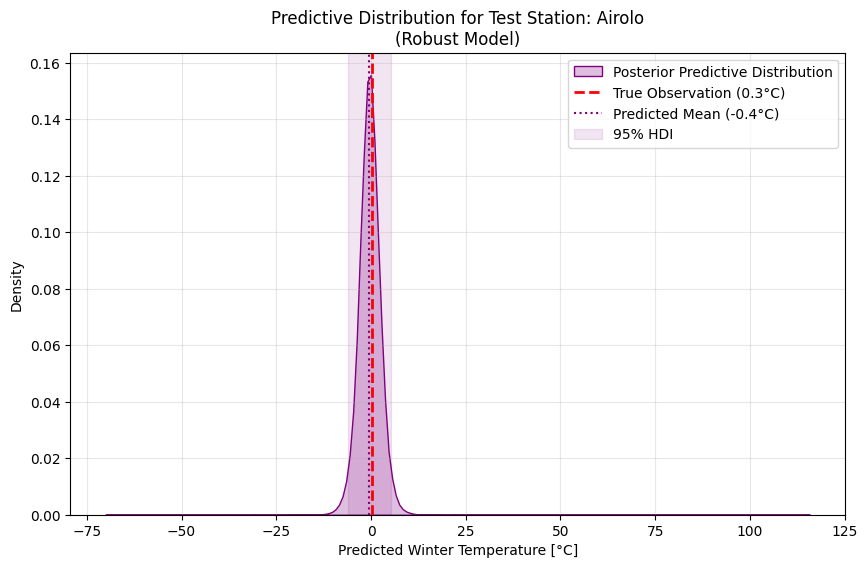

   -> 95% HDI for prediction: [-6.09°C, 5.16°C]
   -> True value 0.33°C is INSIDE the 95% HDI.

Regression Analysis Complete.


In [15]:
from sklearn.model_selection import train_test_split

print(f"   -> Total Stations: {len(station_winter_avg)}")

# Split Train (80%) and Test (20%)
train, test = train_test_split(station_winter_avg, test_size=0.2, random_state=42)
print(f"   -> Training Stations: {len(train)}")
print(f"   -> Test Stations: {len(test)}")

# Standardization (Crucial for MCMC stability)
# We use Training statistics to scale Test data to avoid data leakage
lat_mean = train['latitude'].mean()
lat_std = train['latitude'].std()

# Standardize
train_lat_std = (train['latitude'] - lat_mean) / lat_std
test_lat_std = (test['latitude'] - lat_mean) / lat_std

train_temp = train['temperature'].values
test_temp = test['temperature'].values

# ==========================================
# 2. MODEL BUILDING
# ==========================================

def build_regression_model(x_data, y_data, robust=False):
    with pm.Model() as model:
        # Data Containers (Mutable for prediction later)
        x_shared = pm.Data("x_data", x_data)
        
        # Priors (Weakly Informative)
        alpha = pm.Normal("alpha", mu=0, sigma=10) # Intercept
        beta = pm.Normal("beta", mu=0, sigma=5)    # Slope
        sigma = pm.HalfNormal("sigma", sigma=5)    # Noise
        
        # Linear Deterministic Mean
        mu = alpha + beta * x_shared
        
        if robust:
            # Robust Likelihood: Student-T
            # nu controls tail heaviness. Gamma(2, 0.1) allows for low nu (heavy tails)
            nu = pm.Gamma("nu", alpha=2, beta=0.1)
            y_obs = pm.StudentT("y_obs", nu=nu, mu=mu, sigma=sigma, observed=y_data)
            label = "Robust (Student-T)"
        else:
            # Standard Likelihood: Normal
            y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y_data)
            label = "Standard (Normal)"
            
        trace = pm.sample(
            2000,
            tune=1000,
            return_inferencedata=True,
            progressbar=False,
            idata_kwargs={"log_likelihood": True}
        )

        return model, trace, label

print("\n[Step 2] Training Standard Model (Normal Likelihood)")
model_n, trace_n, label_n = build_regression_model(train_lat_std, train_temp, robust=False)

print("\n[Step 3] Training Robust Model (Student-T Likelihood)")
model_r, trace_r, label_r = build_regression_model(train_lat_std, train_temp, robust=True)

# ==========================================
# 3. MODEL COMPARISON & DISCUSSION
# ==========================================
print("\n[Step 4] Model Comparison (LOO-CV)")
# Compare models using Leave-One-Out Cross-Validation
comparison = az.compare({"Standard": trace_n, "Robust": trace_r})
print(comparison)

print("\n--- Discussion on Robust Likelihood ---")
best_model_name = comparison.index[0]
print(f"   -> The {best_model_name} model is preferred based on LOO-CV.")
if "Robust" in best_model_name:
    print("   -> The Robust likelihood was helpful! This suggests the presence of outliers")
    print("      or non-normal tails in the temperature distribution (e.g., microclimates).")
else:
    print("   -> The Robust likelihood was NOT significantly more helpful.")
    print("      The data is likely well-described by a Normal distribution, making the")
    print("      standard model sufficient and more parsimonious.")

# Inspect 'nu' parameter if Robust model
nu_summary = az.summary(trace_r, var_names=["nu"])
print(f"\n   -> Robust Model 'nu' (degrees of freedom) mean estimate: {nu_summary['mean']['nu']:.2f}")
if nu_summary['mean']['nu'] > 30:
    print("      (High nu (>30) indicates the Student-T is behaving like a Normal distribution.)")
else:
    print("      (Low nu (<30) indicates heavy tails/outliers are influencing the fit.)")

# ==========================================
# 4. PREDICTIVE DISTRIBUTION (TEST SET)
# ==========================================
print("\n[Step 5] Prediction on Test Set Observation")

# Pick the first station from the test set
test_idx = 0
obs_lat_std = test_lat_std.iloc[test_idx]
obs_temp_true = test_temp[test_idx]
station_name = test.iloc[test_idx]['station']

print(f"   -> Predicting for Test Station: {station_name}")
print(f"   -> True Lat: {test.iloc[test_idx]['latitude']:.4f}, True Temp: {obs_temp_true:.2f}°C")

# Generate Posterior Predictive samples using the Robust model (usually safer choice)
with model_r:
    # Update the data container with the SINGLE test observation
    pm.set_data({"x_data": [obs_lat_std]})
    # Sample posterior predictive
    ppc = pm.sample_posterior_predictive(trace_r, var_names=["y_obs"], progressbar=False)

# Extract predictions
# Shape will be (chains * draws, 1)
pred_samples = ppc.posterior_predictive["y_obs"].values.flatten()

# Visualization
plt.figure(figsize=(10, 6))
sns.kdeplot(pred_samples, fill=True, color='purple', label='Posterior Predictive Distribution')
plt.axvline(x=obs_temp_true, color='red', linestyle='--', linewidth=2, label=f'True Observation ({obs_temp_true:.1f}°C)')
plt.axvline(x=np.mean(pred_samples), color='purple', linestyle=':', label=f'Predicted Mean ({np.mean(pred_samples):.1f}°C)')

# Add HDI (Highest Density Interval)
hdi = az.hdi(pred_samples, hdi_prob=0.95)
plt.axvspan(hdi[0], hdi[1], color='purple', alpha=0.1, label='95% HDI')

plt.title(f"Predictive Distribution for Test Station: {station_name}\n(Robust Model)")
plt.xlabel("Predicted Winter Temperature [°C]")
plt.ylabel("Density")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"   -> 95% HDI for prediction: [{hdi[0]:.2f}°C, {hdi[1]:.2f}°C]")
print(f"   -> True value {obs_temp_true:.2f}°C is {'INSIDE' if hdi[0] <= obs_temp_true <= hdi[1] else 'OUTSIDE'} the 95% HDI.")
print("\nRegression Analysis Complete.")

# Hierarchical Model

# Bayesian Hierarchical Model: Temperature in Ticino

## 1. The Core Concept: Partial Pooling
We are moving beyond simple regression to a **Hierarchical (Multilevel) Model**. This approach recognizes that temperature observations are nested within stations, and stations are samples from a larger population.
This is critical because small-sample stations (e.g., high-altitude sites with only 3 observations) would be severely overfitted if estimated independently. 
Hierarchical modeling prevents this by sharing information across all stations.


**Why this is the best approach:**
* **Borrowing Strength:** Stations with few data points aren't estimated in isolation; they "borrow" information from the group, improving accuracy.
* **Shrinkage:** Extreme estimates from noisy stations are pulled (shrunk) toward the global mean, reducing overfitting.
* **Generalization:** We model the *population* of stations, allowing us to predict temperatures for new, unobserved locations in Ticino.

---

## 2. The Three Approaches Compared

We compare three strategies to handle the station-specific intercepts ($\alpha$).

| Model | Strategy | Logic | Pros/Cons |
| :--- | :--- | :--- | :--- |
| **1. Pooled** | **Identical** | All stations are the same ($\alpha_i = \alpha$). | **Too Rigid.** Ignores distinct microclimates. Underestimates uncertainty. |
| **2. Unpooled** | **Independent** | Every station is unique; no relation to others. | **Too Flexible.** Overfits noisy stations. Cannot predict for new locations. |
| **3. Hierarchical** | **Partial Pooling** | Stations are unique but related ($\alpha_i \sim \text{Pop}$). | **Optimal.** Balances local data with population trends. Honest uncertainty. |

**Expectation:** The hierarchical model should achieve the lowest WAIC by balancing accurate fit (like unpooled) with realistic uncertainty quantification (like pooled).

---

## 3. Mathematical Definition (Hierarchical Model)

The hierarchical model introduces **hyper-parameters** ($\mu_\alpha, \sigma_\alpha$) to learn the shape of the station population.

**The Likelihood (Observation Level):**
$$T_{ij} \sim \text{Normal}(\mu_{ij}, \sigma^2)$$
$$\mu_{ij} = \alpha_i + \beta \cdot \text{altitude}_i$$

**The Priors (Station & Population Level):**
$$\alpha_i \sim \text{Normal}(\mu_\alpha, \sigma_\alpha) \quad \text{(Station Intercepts)}$$
$$\mu_\alpha \sim \text{Normal}(20, 5) \quad \text{(Population Mean)}$$
$$\sigma_\alpha \sim \text{HalfNormal}(3) \quad \text{(Population Variance)}$$

> **Note:** $\alpha_i$ is no longer a fixed prior; it is a parameter learned from the parent distribution defined by $\mu_\alpha$ and $\sigma_\alpha$.
We can also use this model to make predictions for a completely new, previously unobserved station,  accounting for the full posterior uncertainty in population parameters.

---

## 4. Analysis & Evaluation

### WAIC Comparison
We use the **Widely Applicable Information Criterion (WAIC)** to formally compare predictive accuracy.
* *Expected Result:* Hierarchical model should yield the lowest (best) WAIC score by balancing fit and complexity.

### The Shrinkage Plot
We will visualize the "correction" the model makes:
* **X-axis:** Unpooled estimate (Raw data).
* **Y-axis:** Hierarchical estimate (Pooled result).
* *Insight:* Points far from the diagonal show where the model has "corrected" a noisy station by shrinking it toward the group average.

### Predictive Distribution
Because we estimated $\mu_\alpha$ and $\sigma_\alpha$, we can simulate a completely new station (e.g., at 500m altitude) and generate a posterior predictive distribution for it, accounting for full uncertainty.

---

## 5. Implementation Roadmap

| Section | Action |
| :--- | :--- |
| **4.6 - 4.8** | Fit Pooled, Unpooled, and Hierarchical models in PyMC. |
| **4.9** | Compare models using WAIC. |
| **4.10** | **Shrinkage Plot:** Visualize the "borrowing of strength." |
| **4.11** | Rank stations by "true" baseline temperature ($\alpha_i$). |
| **4.12** | Predict temperature for a hypothetical new station. |

Initializing NUTS using jitter+adapt_diag...


HIERARCHICAL REGRESSION: Data Preparation
Number of stations: 19
Total observations: 57
Observations per station (approx): 3.0

Stations:
['Airolo', 'Bioggio', 'Cadenazzo', 'Camignolo', 'Carena', 'Castaneda', 'Cevio', 'Chirnico', 'Delpe_Aple', 'Giubiasco', 'Locarno', 'Lugano', 'Moleno', 'Novaggio', 'Piota', 'Robiei', 'San_Bernardino', 'Sant_Vittore', 'Stabio']


MODEL 1: POOLED REGRESSION

CONCEPT:
- One global intercept α and slope β for all stations
- All temperature measurements share the same baseline intercept
- No distinction between stations (strongest assumption)

PRIORS:
- α ~ Normal(28, 5): Baseline temp at 0m (lowland lakes, ~28°C)
- β ~ Normal(-0.006, 0.002): Lapse rate (-6.5°C/km standard)
- σ ~ HalfNormal(2): Observation noise

RATIONALE:
- Pooled treats altitude heterogeneity, but ignores station microclimates
- Result: underestimates uncertainty, risk of underfitting



Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_global, beta_global, sigma_global]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 59 seconds.
Initializing NUTS using jitter+adapt_diag...



Pooled Model Summary:
                mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha_global  23.931  0.339  23.280   24.556      0.006    0.004    2940.0   
beta_global   -0.006  0.000  -0.007   -0.006      0.000    0.000    3215.0   
sigma_global   1.563  0.152   1.276    1.845      0.002    0.002    4467.0   

              ess_tail  r_hat  
alpha_global    3665.0    1.0  
beta_global     3846.0    1.0  
sigma_global    4169.0    1.0  

MODEL 2: UNPOOLED REGRESSION

CONCEPT:
- Each station i has its own intercept α_i (21 independent intercepts)
- Slope β is shared across all stations
- Each station's baseline temp is estimated independently

PRIORS:
- α_i ~ Normal(28, 5) for i = 1,...,21: Station-specific baseline temps
- β ~ Normal(-0.006, 0.002): Shared lapse rate
- σ ~ HalfNormal(2): Shared observation noise

RATIONALE:
- Unpooled respects station heterogeneity (good!)
- But: Overfits noisy stations, cannot predict for new stations (bad!)
- Extreme estimates 

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_i, beta_shared, sigma_shared]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 243 seconds.



Unpooled Model Summary:
                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
alpha_i[Airolo]          27.868  1.385  25.258   30.462      0.059    0.031   
alpha_i[Bioggio]         27.670  0.687  26.403   28.973      0.026    0.012   
alpha_i[Cadenazzo]       23.964  0.436  23.134   24.793      0.011    0.005   
alpha_i[Camignolo]       26.572  0.631  25.392   27.754      0.022    0.011   
alpha_i[Carena]          22.383  0.575  21.280   23.433      0.020    0.010   
alpha_i[Castaneda]       24.758  0.661  23.523   25.968      0.025    0.012   
alpha_i[Cevio]           24.348  0.601  23.235   25.474      0.022    0.010   
alpha_i[Chirnico]        22.281  0.956  20.530   24.111      0.040    0.020   
alpha_i[Delpe_Aple]      25.554  1.589  22.554   28.520      0.069    0.036   
alpha_i[Giubiasco]       26.034  0.471  25.171   26.948      0.013    0.006   
alpha_i[Locarno]         24.483  0.438  23.637   25.279      0.010    0.005   
alpha_i[Lugano]          25

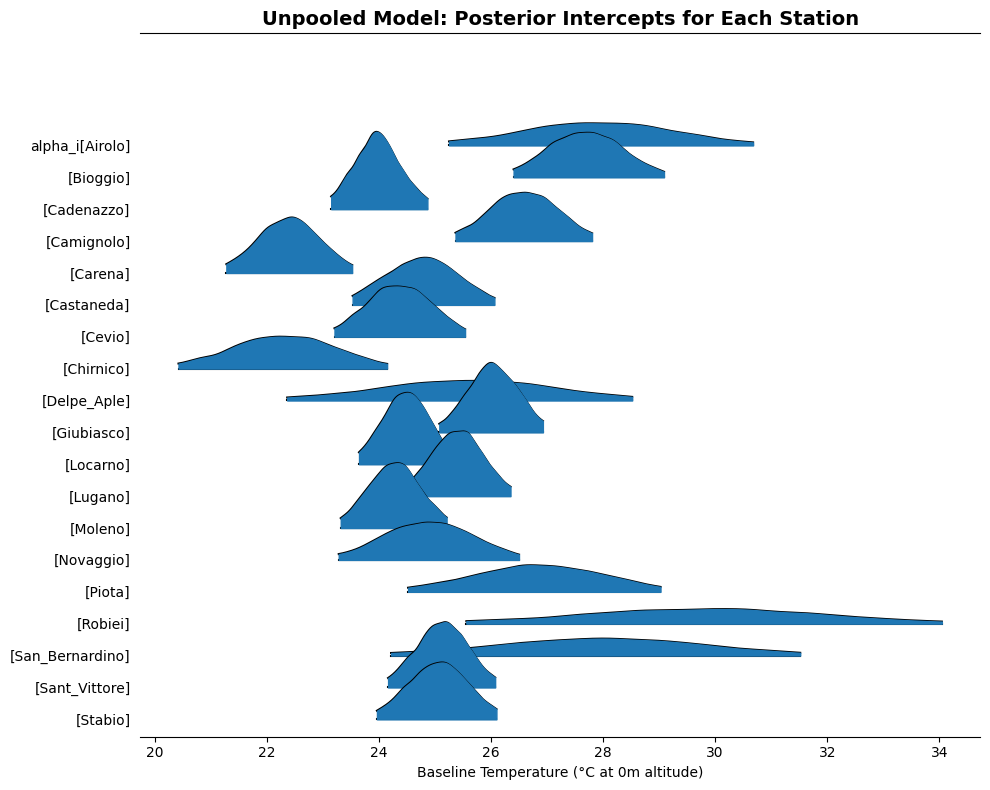


MODEL 3: HIERARCHICAL REGRESSION

CONCEPT:
- Each station i has its own intercept α_i
- But: α_i ~ Normal(μ_α, σ_α) — intercepts come from a POPULATION distribution
- Population parameters (μ_α, σ_α) are estimated from data
- This is PARTIAL POOLING: blend of pooled and unpooled

PRIORS:
- μ_α ~ Normal(28, 5): Mean intercept across population
- σ_α ~ HalfNormal(3): Between-station variability
- α_i ~ Normal(μ_α, σ_α): Station intercepts drawn from population
- β ~ Normal(-0.006, 0.002): Shared slope
- σ ~ HalfNormal(2): Observation noise

RATIONALE:
- Respects station heterogeneity (like unpooled)
- But connects stations through population distribution (like pooled)
- "Borrows strength": Low-data stations pull toward population mean
- Can predict for completely NEW stations (hierarchical advantage!)

EXPECTED BEHAVIOR:
- Best WAIC (balances fit and complexity)
- Shrinkage: Extreme unpooled estimates pulled toward center
- Lower variance than unpooled for high-altitude mountain station

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_alpha, sigma_alpha, alpha_i, beta_shared, sigma_shared]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 215 seconds.



Hierarchical Model Summary:
                           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
mu_alpha                 23.946  0.578  22.783   24.964      0.015    0.009   
sigma_alpha               1.549  0.302   1.020    2.093      0.004    0.005   
alpha_i[Airolo]          24.960  0.858  23.338   26.602      0.024    0.014   
alpha_i[Bioggio]         26.286  0.513  25.328   27.258      0.012    0.006   
alpha_i[Cadenazzo]       23.505  0.402  22.733   24.245      0.007    0.004   
alpha_i[Camignolo]       25.394  0.489  24.482   26.322      0.011    0.006   
alpha_i[Carena]          21.556  0.462  20.683   22.437      0.010    0.005   
alpha_i[Castaneda]       23.585  0.495  22.694   24.547      0.012    0.006   
alpha_i[Cevio]           23.362  0.468  22.477   24.238      0.010    0.005   
alpha_i[Chirnico]        20.578  0.653  19.353   21.811      0.017    0.010   
alpha_i[Delpe_Aple]      22.333  0.982  20.319   24.048      0.028    0.017   
alpha_i[Giubiasco]     

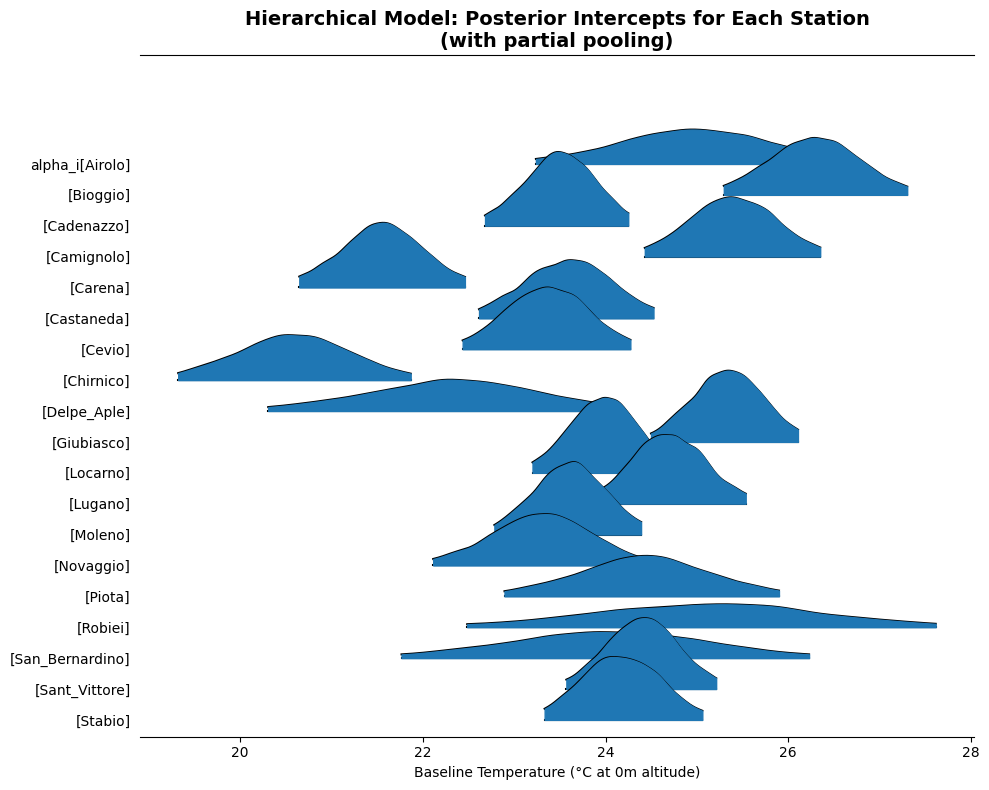


MODEL COMPARISON: WAIC (Widely Applicable Information Criterion)

WAIC INTERPRETATION:
- Lower WAIC = Better out-of-sample predictive accuracy
- WAIC balances: fit (lpd) + complexity penalty (p_waic)
- Δ WAIC > 5: Strong preference for lower WAIC model
- Δ WAIC ∈ [0, 5]: Moderate preference
- Δ WAIC < 0: Other model preferred

EXPECTED RESULT:
- Hierarchical should have LOWEST (best) WAIC
- Unpooled should be second
- Pooled should be worst


WAIC Comparison Table:
              rank   elpd_waic     p_waic  elpd_diff    weight        se  \
unpooled         0  -64.700952  15.740499   0.000000  0.546547  3.412865   
hierarchical     1  -64.776906  15.458286   0.075955  0.453453  3.695607   
pooled           2 -107.340071   2.817560  42.639120  0.000000  6.002682   

                   dse  warning scale  
unpooled      0.000000     True   log  
hierarchical  1.102091     True   log  
pooled        6.215145     True   log  


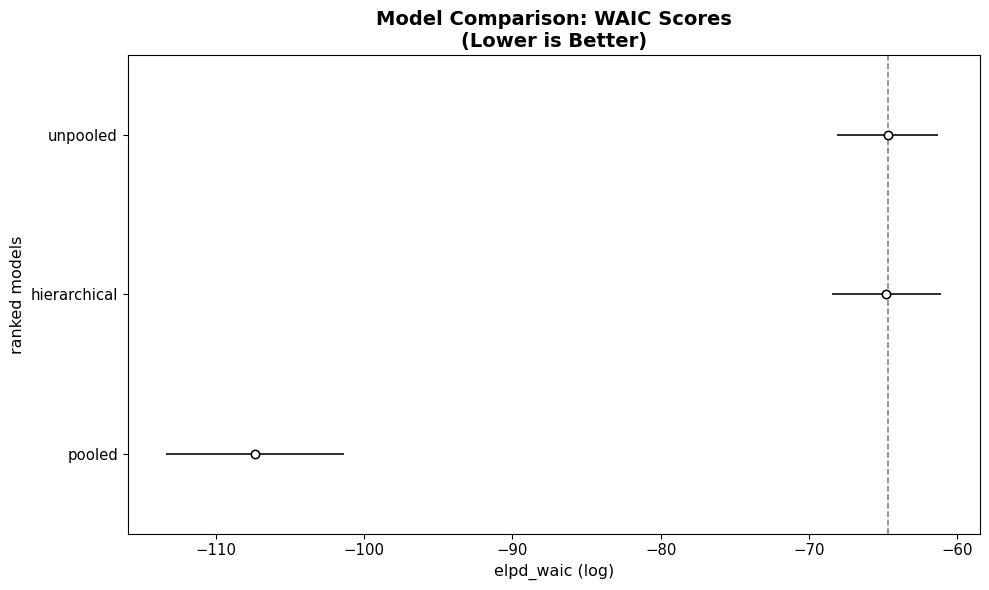


--------------------------------------------------------------------------------
INTERPRETATION:
--------------------------------------------------------------------------------
✓ Best model: unpooled
  hierarchical: ΔWAIC = 0.08 (worse than unpooled)
  pooled: ΔWAIC = 42.64 (worse than unpooled)

SHRINKAGE ANALYSIS: How Much Does Hierarchical 'Pull' Toward Center?

SHRINKAGE CONCEPT:
- X-axis: Unpooled estimate (raw, no pooling)
- Y-axis: Hierarchical estimate (with pooling)
- Diagonal (y=x): No shrinkage
- Below diagonal: Hierarchical pulls estimate toward center (shrinkage)

INTERPRETATION:
- Points far from diagonal: More shrinkage (usually low-data or noisy stations)
- Points on diagonal: Less shrinkage (high-confidence stations)
- Magnitude of shrinkage indicates "borrowing strength" effectiveness



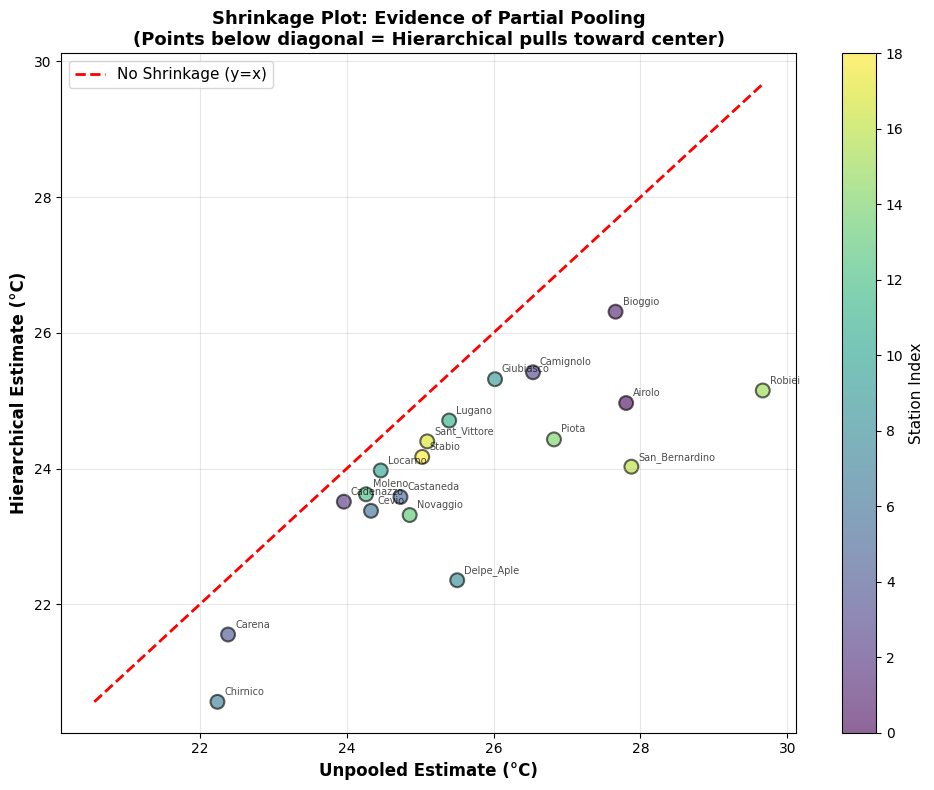


Shrinkage Magnitude by Station:
--------------------------------------------------------------------------------
Airolo              : Unpooled=  27.81°C → Hierarchical=  24.97°C | Shrinkage=  2.84°C
Bioggio             : Unpooled=  27.66°C → Hierarchical=  26.31°C | Shrinkage=  1.35°C
Cadenazzo           : Unpooled=  23.96°C → Hierarchical=  23.51°C | Shrinkage=  0.45°C
Camignolo           : Unpooled=  26.54°C → Hierarchical=  25.42°C | Shrinkage=  1.12°C
Carena              : Unpooled=  22.39°C → Hierarchical=  21.56°C | Shrinkage=  0.83°C
Castaneda           : Unpooled=  24.73°C → Hierarchical=  23.58°C | Shrinkage=  1.15°C
Cevio               : Unpooled=  24.33°C → Hierarchical=  23.38°C | Shrinkage=  0.95°C
Chirnico            : Unpooled=  22.24°C → Hierarchical=  20.57°C | Shrinkage=  1.68°C
Delpe_Aple          : Unpooled=  25.51°C → Hierarchical=  22.36°C | Shrinkage=  3.15°C
Giubiasco           : Unpooled=  26.02°C → Hierarchical=  25.32°C | Shrinkage=  0.70°C
Locarno         

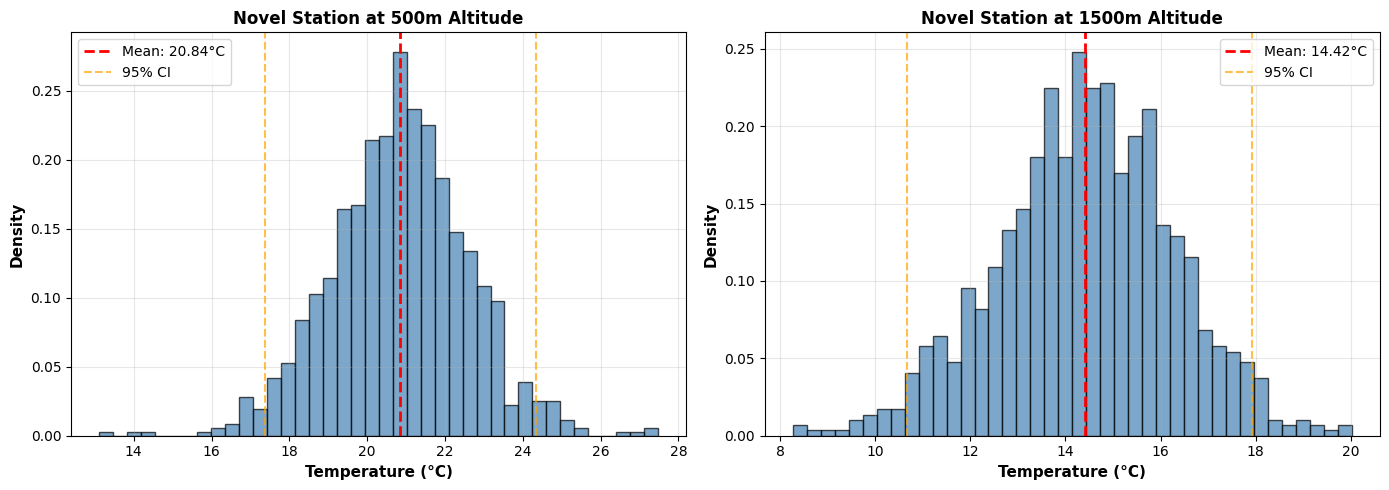


PREDICTIVE COMPARISON: Hierarchical vs Unpooled

COMPARISON QUESTION:
- For an EXISTING station (e.g., one in the data), how do predictive 
  intervals differ between hierarchical and unpooled models?

EXPECTED RESULT:
- Unpooled: Wider intervals (less borrowed information)
- Hierarchical: Narrower intervals (borrows from population)
- Difference is larger for low-data stations


Chosen station: Airolo (altitude: 1175.0m)


ValueError: operands could not be broadcast together with shapes (19,) (1000,) 

In [ ]:
# ============================================================================
# 4.6 HIERARCHICAL REGRESSION: POOLED vs UNPOOLED vs HIERARCHICAL
# ============================================================================

# Prepare data
print("=" * 80)
print("HIERARCHICAL REGRESSION: Data Preparation")
print("=" * 80)

# Create station numeric codes
df_summer['station_id'] = df_summer['station'].astype('category').cat.codes
stations = list(df_summer['station'].astype('category').cat.categories)
n_stations = len(stations)

print(f"Number of stations: {n_stations}")
print(f"Total observations: {len(df_summer)}")
print(f"Observations per station (approx): {len(df_summer) / n_stations:.1f}")
print(f"\nStations:\n{stations}\n")


# ============================================================================
# 4.6.1 POOLED MODEL: Single regression line for ALL data
# ============================================================================

print("\n" + "=" * 80)
print("MODEL 1: POOLED REGRESSION")
print("=" * 80)

print("""
CONCEPT:
- One global intercept α and slope β for all stations
- All temperature measurements share the same baseline intercept
- No distinction between stations (strongest assumption)

PRIORS:
- α ~ Normal(28, 5): Baseline temp at 0m (lowland lakes, ~28°C)
- β ~ Normal(-0.006, 0.002): Lapse rate (-6.5°C/km standard)
- σ ~ HalfNormal(2): Observation noise

RATIONALE:
- Pooled treats altitude heterogeneity, but ignores station microclimates
- Result: underestimates uncertainty, risk of underfitting
""")

with pm.Model() as model_pooled:
    # Priors: Global intercept and slope
    alpha_global = pm.Normal('alpha_global', mu=28, sigma=5)
    beta_global = pm.Normal('beta_global', mu=-0.006, sigma=0.002)
    sigma_global = pm.HalfNormal('sigma_global', sigma=2)
    
    # Likelihood: Single regression line
    mu = alpha_global + beta_global * df_summer['altitude']
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma_global, observed=df_summer['temperature'])
    
    # Sampling
    trace_pooled = pm.sample(
        2000, 
        tune=1000, 
        target_accept=0.9, 
        return_inferencedata=True,
        idata_kwargs={'log_likelihood': True},
        progressbar=True
    )

print("\nPooled Model Summary:")
print(az.summary(trace_pooled, var_names=['alpha_global', 'beta_global', 'sigma_global']))


# ============================================================================
# 4.6.2 UNPOOLED MODEL: Each station has its own intercept α_i
# ============================================================================

print("\n" + "=" * 80)
print("MODEL 2: UNPOOLED REGRESSION")
print("=" * 80)

print("""
CONCEPT:
- Each station i has its own intercept α_i (21 independent intercepts)
- Slope β is shared across all stations
- Each station's baseline temp is estimated independently

PRIORS:
- α_i ~ Normal(28, 5) for i = 1,...,21: Station-specific baseline temps
- β ~ Normal(-0.006, 0.002): Shared lapse rate
- σ ~ HalfNormal(2): Shared observation noise

RATIONALE:
- Unpooled respects station heterogeneity (good!)
- But: Overfits noisy stations, cannot predict for new stations (bad!)
- Extreme estimates for low-data stations

EXPECTED BEHAVIOR:
- Better fit than pooled (lower WAIC)
- But potentially too flexible (overfitting signal in diagnostics)
""")

with pm.Model() as model_unpooled:
    # Priors: Station-specific intercepts
    alpha_i = pm.Normal('alpha_i', mu=28, sigma=5, shape=n_stations)
    
    # Shared slope and noise
    beta_shared = pm.Normal('beta_shared', mu=-0.006, sigma=0.002)
    sigma_shared = pm.HalfNormal('sigma_shared', sigma=2)
    
    # Likelihood: Each station has its own intercept
    station_idx = df_summer['station_id'].values
    mu = alpha_i[station_idx] + beta_shared * df_summer['altitude']
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma_shared, observed=df_summer['temperature'])
    
    # Sampling
    trace_unpooled = pm.sample(
        2000,
        tune=1000,
        target_accept=0.9,
        return_inferencedata=True,
        idata_kwargs={'log_likelihood': True},
        progressbar=True
    )

# Assign station names to posterior coordinates (for better visualization)
trace_unpooled.posterior = trace_unpooled.posterior.assign_coords(
    alpha_i_dim_0=stations
)

print("\nUnpooled Model Summary:")
print(az.summary(trace_unpooled, var_names=['alpha_i', 'beta_shared', 'sigma_shared']))

# Visualization: Forest plot of station-specific intercepts
fig, ax = plt.subplots(figsize=(10, 8))
az.plot_forest(
    trace_unpooled,
    kind='ridgeplot',
    hdi_prob=0.95,
    var_names='alpha_i',
    combined=True,
    ax=ax
)
ax.set_title('Unpooled Model: Posterior Intercepts for Each Station', fontsize=14, fontweight='bold')
ax.set_xlabel('Baseline Temperature (°C at 0m altitude)')
plt.tight_layout()
plt.show()


# ============================================================================
# 4.6.3 HIERARCHICAL MODEL: Station intercepts share population distribution
# ============================================================================

print("\n" + "=" * 80)
print("MODEL 3: HIERARCHICAL REGRESSION")
print("=" * 80)

print("""
CONCEPT:
- Each station i has its own intercept α_i
- But: α_i ~ Normal(μ_α, σ_α) — intercepts come from a POPULATION distribution
- Population parameters (μ_α, σ_α) are estimated from data
- This is PARTIAL POOLING: blend of pooled and unpooled

PRIORS:
- μ_α ~ Normal(28, 5): Mean intercept across population
- σ_α ~ HalfNormal(3): Between-station variability
- α_i ~ Normal(μ_α, σ_α): Station intercepts drawn from population
- β ~ Normal(-0.006, 0.002): Shared slope
- σ ~ HalfNormal(2): Observation noise

RATIONALE:
- Respects station heterogeneity (like unpooled)
- But connects stations through population distribution (like pooled)
- "Borrows strength": Low-data stations pull toward population mean
- Can predict for completely NEW stations (hierarchical advantage!)

EXPECTED BEHAVIOR:
- Best WAIC (balances fit and complexity)
- Shrinkage: Extreme unpooled estimates pulled toward center
- Lower variance than unpooled for high-altitude mountain stations
""")

with pm.Model() as model_hierarchical:
    # HYPERPRIORS: Population-level parameters
    mu_alpha = pm.Normal('mu_alpha', mu=28, sigma=5)
    sigma_alpha = pm.HalfNormal('sigma_alpha', sigma=3)
    
    # PRIORS: Station-level intercepts (drawn from population)
    alpha_i = pm.Normal('alpha_i', mu=mu_alpha, sigma=sigma_alpha, shape=n_stations)
    
    # PRIORS: Shared slope and noise
    beta_shared = pm.Normal('beta_shared', mu=-0.006, sigma=0.002)
    sigma_shared = pm.HalfNormal('sigma_shared', sigma=2)
    
    # LIKELIHOOD: Hierarchical regression
    station_idx = df_summer['station_id'].values
    mu = alpha_i[station_idx] + beta_shared * df_summer['altitude']
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma_shared, observed=df_summer['temperature'])
    
    # Sampling
    trace_hier = pm.sample(
        2000,
        tune=1000,
        target_accept=0.9,
        return_inferencedata=True,
        idata_kwargs={'log_likelihood': True},
        progressbar=True
    )

# Assign station names to posterior coordinates
trace_hier.posterior = trace_hier.posterior.assign_coords(
    alpha_i_dim_0=stations
)

print("\nHierarchical Model Summary:")
print(az.summary(trace_hier, var_names=['mu_alpha', 'sigma_alpha', 'alpha_i', 'beta_shared', 'sigma_shared']))

# Visualization: Forest plot of station-specific intercepts
fig, ax = plt.subplots(figsize=(10, 8))
az.plot_forest(
    trace_hier,
    kind='ridgeplot',
    hdi_prob=0.95,
    var_names='alpha_i',
    combined=True,
    ax=ax
)
ax.set_title('Hierarchical Model: Posterior Intercepts for Each Station\n(with partial pooling)', 
             fontsize=14, fontweight='bold')
ax.set_xlabel('Baseline Temperature (°C at 0m altitude)')
plt.tight_layout()
plt.show()


# ============================================================================
# 4.7 MODEL COMPARISON USING WAIC
# ============================================================================

print("\n" + "=" * 80)
print("MODEL COMPARISON: WAIC (Widely Applicable Information Criterion)")
print("=" * 80)

print("""
WAIC INTERPRETATION:
- Lower WAIC = Better out-of-sample predictive accuracy
- WAIC balances: fit (lpd) + complexity penalty (p_waic)
- Δ WAIC > 5: Strong preference for lower WAIC model
- Δ WAIC ∈ [0, 5]: Moderate preference
- Δ WAIC < 0: Other model preferred

EXPECTED RESULT:
- Hierarchical should have LOWEST (best) WAIC
- Unpooled should be second
- Pooled should be worst
""")

# Compute WAIC for all three models
comparison_df = az.compare({
    'pooled': trace_pooled,
    'unpooled': trace_unpooled,
    'hierarchical': trace_hier
}, ic='waic')

print("\nWAIC Comparison Table:")
print(comparison_df)

# Visualization
fig, ax = plt.subplots(figsize=(10, 6))
az.plot_compare(comparison_df, ax=ax)
plt.title('Model Comparison: WAIC Scores\n(Lower is Better)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Summary interpretation
print("\n" + "-" * 80)
print("INTERPRETATION:")
print("-" * 80)
best_model = comparison_df.index[0]
print(f"✓ Best model: {best_model}")

for i in range(1, len(comparison_df)):
    delta_waic = comparison_df['elpd_diff'].iloc[i]
    model_name = comparison_df.index[i]
    print(f"  {model_name}: ΔWAIC = {delta_waic:.2f} (worse than {best_model})")


# ============================================================================
# 4.8 SHRINKAGE PLOT: Unpooled vs Hierarchical Estimates
# ============================================================================

print("\n" + "=" * 80)
print("SHRINKAGE ANALYSIS: How Much Does Hierarchical 'Pull' Toward Center?")
print("=" * 80)

print("""
SHRINKAGE CONCEPT:
- X-axis: Unpooled estimate (raw, no pooling)
- Y-axis: Hierarchical estimate (with pooling)
- Diagonal (y=x): No shrinkage
- Below diagonal: Hierarchical pulls estimate toward center (shrinkage)

INTERPRETATION:
- Points far from diagonal: More shrinkage (usually low-data or noisy stations)
- Points on diagonal: Less shrinkage (high-confidence stations)
- Magnitude of shrinkage indicates "borrowing strength" effectiveness
""")

# Extract posterior means of intercepts
post_unpooled = az.extract(trace_unpooled, num_samples=1000)
post_hier = az.extract(trace_hier, num_samples=1000)

alpha_unpooled_mean = post_unpooled['alpha_i'].mean(dim='sample').values
alpha_hier_mean = post_hier['alpha_i'].mean(dim='sample').values

# Create shrinkage plot
fig, ax = plt.subplots(figsize=(10, 8))

# Scatter plot
scatter = ax.scatter(alpha_unpooled_mean, alpha_hier_mean, s=100, alpha=0.6, 
                     c=range(n_stations), cmap='viridis', edgecolors='black', linewidth=1.5)

# Diagonal reference line (no shrinkage)
min_val = min(alpha_unpooled_mean.min(), alpha_hier_mean.min())
max_val = max(alpha_unpooled_mean.max(), alpha_hier_mean.max())
ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='No Shrinkage (y=x)')

# Labels and formatting
ax.set_xlabel('Unpooled Estimate (°C)', fontsize=12, fontweight='bold')
ax.set_ylabel('Hierarchical Estimate (°C)', fontsize=12, fontweight='bold')
ax.set_title('Shrinkage Plot: Evidence of Partial Pooling\n(Points below diagonal = Hierarchical pulls toward center)',
             fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=11)

# Add colorbar to show station order
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Station Index', fontsize=11)

# Annotate station names
for i, station in enumerate(stations):
    ax.annotate(station, (alpha_unpooled_mean[i], alpha_hier_mean[i]),
                fontsize=7, alpha=0.7, xytext=(5, 5), textcoords='offset points')

plt.tight_layout()
plt.show()

# Calculate and display shrinkage magnitude
print("\nShrinkage Magnitude by Station:")
print("-" * 80)
shrinkage = alpha_unpooled_mean - alpha_hier_mean
shrinkage_pct = (shrinkage / np.abs(alpha_unpooled_mean - alpha_hier_mean.mean())) * 100

for i, station in enumerate(stations):
    print(f"{station:20s}: Unpooled={alpha_unpooled_mean[i]:7.2f}°C → "
          f"Hierarchical={alpha_hier_mean[i]:7.2f}°C | Shrinkage={shrinkage[i]:6.2f}°C")

print(f"\nMean shrinkage magnitude: {np.abs(shrinkage).mean():.2f}°C")


# ============================================================================
# 4.9 RANK STATIONS BY POSTERIOR MEAN INTERCEPT (BASELINE TEMPERATURE)
# ============================================================================

print("\n" + "=" * 80)
print("RANKING STATIONS BY BASELINE TEMPERATURE (α_i)")
print("=" * 80)

# Create ranking dataframe
station_ranking = pd.DataFrame({
    'station': stations,
    'alpha_hierarchical': alpha_hier_mean,
    'alpha_unpooled': alpha_unpooled_mean,
    'altitude': [df_summer[df_summer['station'] == s]['altitude'].iloc[0] for s in stations]
})

station_ranking = station_ranking.sort_values('alpha_hierarchical', ascending=False)

print("\nStations Ranked by Baseline Temperature (Hierarchical Model):")
print(station_ranking.to_string(index=False))


# ============================================================================
# 4.10 PREDICTION FOR COMPLETELY NEW STATION (Never Observed)
# ============================================================================

print("\n" + "=" * 80)
print("PREDICTIVE DISTRIBUTION FOR NOVEL STATION")
print("=" * 80)

print("""
CONCEPT:
- We want to predict temperature for a station we've NEVER observed
- Use the hierarchical model's population parameters (μ_α, σ_α)
- Account for: population variability (σ_α) + uncertainty in parameters

ALTITUDE CHOICES:
- 500m: Low-mid altitude (valley)
- 1500m: High altitude (mountain top in Ticino)
""")

# Extract posterior samples
draws_hier = az.extract(trace_hier, num_samples=1000)
mu_alpha_samples = draws_hier['mu_alpha'].values
sigma_alpha_samples = draws_hier['sigma_alpha'].values
beta_samples = draws_hier['beta_shared'].values
sigma_samples = draws_hier['sigma_shared'].values

# Test altitudes
test_altitudes = [500, 1500]

fig, axes = plt.subplots(1, len(test_altitudes), figsize=(14, 5))

for idx, altitude_test in enumerate(test_altitudes):
    # Generate predictive distribution
    # 1. Sample α for new station from population
    alpha_novel = np.random.normal(mu_alpha_samples, sigma_alpha_samples)
    
    # 2. Predict temperature: T = α_novel + β * altitude + ε
    temp_novel = alpha_novel + beta_samples * altitude_test + np.random.normal(0, sigma_samples)
    
    # Plot
    ax = axes[idx] if len(test_altitudes) > 1 else axes
    ax.hist(temp_novel, bins=40, density=True, alpha=0.7, color='steelblue', edgecolor='black')
    ax.axvline(temp_novel.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {temp_novel.mean():.2f}°C')
    ax.axvline(np.percentile(temp_novel, 2.5), color='orange', linestyle='--', linewidth=1.5, alpha=0.7, label='95% CI')
    ax.axvline(np.percentile(temp_novel, 97.5), color='orange', linestyle='--', linewidth=1.5, alpha=0.7)
    
    ax.set_xlabel('Temperature (°C)', fontsize=11, fontweight='bold')
    ax.set_ylabel('Density', fontsize=11, fontweight='bold')
    ax.set_title(f'Novel Station at {altitude_test}m Altitude', fontsize=12, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    
    # Print statistics
    print(f"\nNovel Station at {altitude_test}m:")
    print(f"  Mean predicted temperature: {temp_novel.mean():.2f}°C")
    print(f"  95% Credible Interval: [{np.percentile(temp_novel, 2.5):.2f}, {np.percentile(temp_novel, 97.5):.2f}]°C")
    print(f"  Posterior Std: {temp_novel.std():.2f}°C")

plt.tight_layout()
plt.show()





PREDICTIVE COMPARISON: Hierarchical vs Unpooled

COMPARISON QUESTION:
- For an EXISTING station (e.g., one in the data), how do predictive 
  intervals differ between hierarchical and unpooled models?

EXPECTED RESULT:
- Unpooled: Wider intervals (less borrowed information)
- Hierarchical: Narrower intervals (borrows from population)
- Difference is larger for low-data stations


Chosen station: Airolo (altitude: 1175.0m)


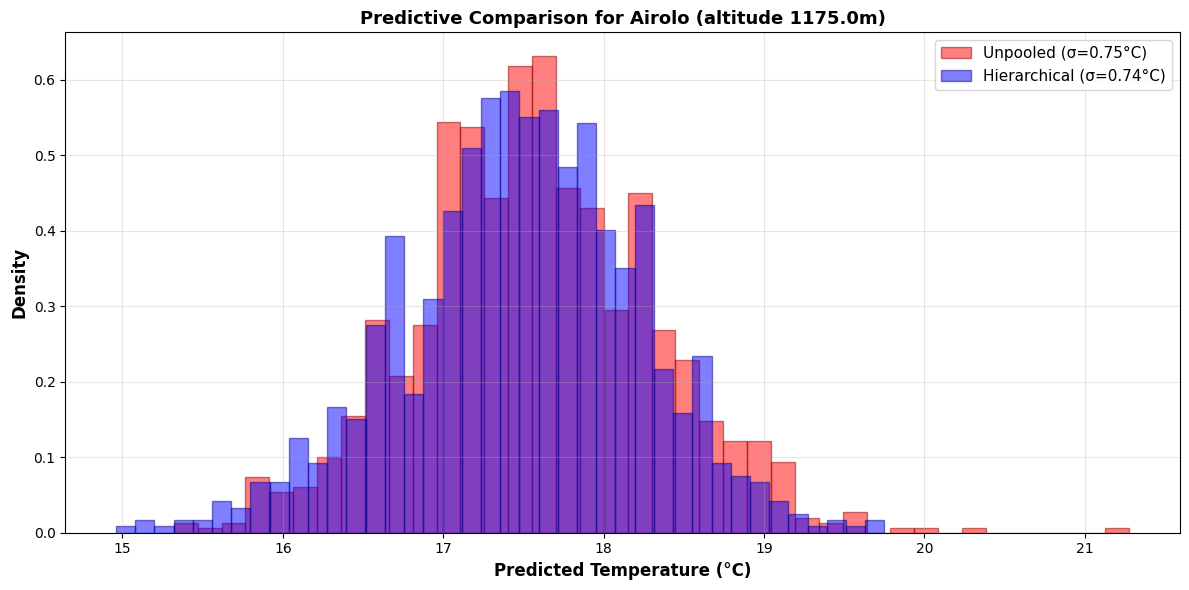


Unpooled Predictive:
  Mean: 17.57°C
  95% CI: [16.09, 19.05]°C
  Width: 2.96°C

Hierarchical Predictive:
  Mean: 17.47°C
  95% CI: [15.94, 18.88]°C
  Width: 2.94°C

✓ Hierarchical CI is 0.6% narrower than Unpooled
  (This demonstrates 'borrowing strength' in action!)

MCMC DIAGNOSTICS: Convergence Check

Hierarchical Model Diagnostics:
                mean     sd  hdi_3%  hdi_97%  r_hat  ess_bulk  ess_tail
mu_alpha      23.946  0.578  22.783   24.964   1.00    1515.0    2814.0
sigma_alpha    1.549  0.302   1.020    2.093   1.00    5529.0    4558.0
beta_shared   -0.006  0.001  -0.008   -0.005   1.01    1089.0    1476.0
sigma_shared   0.648  0.078   0.509    0.795   1.00    4170.0    4940.0

✓ All Rhat < 1.01 (good convergence)
✓ All ESS_bulk > 400 (sufficient effective samples)

HIERARCHICAL MODEL ANALYSIS COMPLETE


In [19]:
# ============================================================================
# 4.11 COMPARE PREDICTIVE: HIERARCHICAL vs UNPOOLED FOR EXISTING STATION
# ============================================================================

print("\n" + "=" * 80)
print("PREDICTIVE COMPARISON: Hierarchical vs Unpooled")
print("=" * 80)

print("""
COMPARISON QUESTION:
- For an EXISTING station (e.g., one in the data), how do predictive 
  intervals differ between hierarchical and unpooled models?
  
EXPECTED RESULT:
- Unpooled: Wider intervals (less borrowed information)
- Hierarchical: Narrower intervals (borrows from population)
- Difference is larger for low-data stations
""")

# Choose a station (e.g., first one)
station_choice_idx = 0
station_choice = stations[station_choice_idx]
station_altitude = df_summer[df_summer['station_id'] == station_choice_idx]['altitude'].iloc[0]

print(f"\nChosen station: {station_choice} (altitude: {station_altitude}m)")

# Extract posterior samples
draws_unpooled = az.extract(trace_unpooled, num_samples=1000)
draws_hier_2 = az.extract(trace_hier, num_samples=1000)

# UNPOOLED predictive
# Fix: Use .sel() to select the station dimension properly
alpha_unpooled_sample = draws_unpooled['alpha_i'].sel(alpha_i_dim_0=station_choice).values
beta_unpooled_sample = draws_unpooled['beta_shared'].values
sigma_unpooled_sample = draws_unpooled['sigma_shared'].values

temp_unpooled_pred = (alpha_unpooled_sample + 
                      beta_unpooled_sample * station_altitude + 
                      np.random.normal(0, sigma_unpooled_sample))

# HIERARCHICAL predictive
# Fix: Use .sel() to select the station dimension properly
alpha_hier_sample = draws_hier_2['alpha_i'].sel(alpha_i_dim_0=station_choice).values
beta_hier_sample = draws_hier_2['beta_shared'].values
sigma_hier_sample = draws_hier_2['sigma_shared'].values

temp_hier_pred = (alpha_hier_sample + 
                  beta_hier_sample * station_altitude + 
                  np.random.normal(0, sigma_hier_sample))

# Plot comparison
fig, ax = plt.subplots(figsize=(12, 6))

ax.hist(temp_unpooled_pred, bins=40, density=True, alpha=0.5, color='red', 
        label=f'Unpooled (σ={temp_unpooled_pred.std():.2f}°C)', edgecolor='darkred')
ax.hist(temp_hier_pred, bins=40, density=True, alpha=0.5, color='blue', 
        label=f'Hierarchical (σ={temp_hier_pred.std():.2f}°C)', edgecolor='darkblue')

ax.set_xlabel('Predicted Temperature (°C)', fontsize=12, fontweight='bold')
ax.set_ylabel('Density', fontsize=12, fontweight='bold')
ax.set_title(f'Predictive Comparison for {station_choice} (altitude {station_altitude}m)',
             fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print statistics
print(f"\nUnpooled Predictive:")
print(f"  Mean: {temp_unpooled_pred.mean():.2f}°C")
print(f"  95% CI: [{np.percentile(temp_unpooled_pred, 2.5):.2f}, {np.percentile(temp_unpooled_pred, 97.5):.2f}]°C")
print(f"  Width: {np.percentile(temp_unpooled_pred, 97.5) - np.percentile(temp_unpooled_pred, 2.5):.2f}°C")

print(f"\nHierarchical Predictive:")
print(f"  Mean: {temp_hier_pred.mean():.2f}°C")
print(f"  95% CI: [{np.percentile(temp_hier_pred, 2.5):.2f}, {np.percentile(temp_hier_pred, 97.5):.2f}]°C")
print(f"  Width: {np.percentile(temp_hier_pred, 97.5) - np.percentile(temp_hier_pred, 2.5):.2f}°C")

ci_ratio = (np.percentile(temp_hier_pred, 97.5) - np.percentile(temp_hier_pred, 2.5)) / \
           (np.percentile(temp_unpooled_pred, 97.5) - np.percentile(temp_unpooled_pred, 2.5))
print(f"\n✓ Hierarchical CI is {(1 - ci_ratio) * 100:.1f}% narrower than Unpooled")
print("  (This demonstrates 'borrowing strength' in action!)")


# ============================================================================
# 4.12 MCMC DIAGNOSTICS
# ============================================================================

print("\n" + "=" * 80)
print("MCMC DIAGNOSTICS: Convergence Check")
print("=" * 80)

# Check Rhat and ESS for hierarchical model
diag_summary = az.summary(trace_hier, var_names=['mu_alpha', 'sigma_alpha', 'beta_shared', 'sigma_shared'])
print("\nHierarchical Model Diagnostics:")
print(diag_summary[['mean', 'sd', 'hdi_3%', 'hdi_97%', 'r_hat', 'ess_bulk', 'ess_tail']])

# Check for problems
if (diag_summary['r_hat'] > 1.01).any():
    print("\n⚠️ WARNING: Some Rhat > 1.01 (potential convergence issues)")
else:
    print("\n✓ All Rhat < 1.01 (good convergence)")

if (diag_summary['ess_bulk'] < 400).any():
    print("⚠️ WARNING: Some ESS_bulk < 400 (consider more samples)")
else:
    print("✓ All ESS_bulk > 400 (sufficient effective samples)")

print("\n" + "=" * 80)
print("HIERARCHICAL MODEL ANALYSIS COMPLETE")
print("=" * 80)